In [89]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import math
from timeit import default_timer as timer
from datetime import datetime, timedelta
import numba
from ensemble_processing import load_data, load, save


In [90]:
pd.options.display.max_rows=500
pd.options.display.max_columns=500

In [94]:
# Load and augment data
all_df = pd.read_pickle('../data/ml-20180922-labelled.pkl.gz', compression='gzip')
# experiment_symbols = ['WAX', 'IVV', 'WESN', 'IAA', 'XRO', 'MTB', 'MXR', 'RCP', 'ISX', 'IMI']
experiment_symbols = ['GSW','CUA','FLT','OVN','FDM','SVW','FPH','JHC','TRS','SGP','DOW','AOG',
                      'HSN','SWM','CMI','BCI','SWJ','MYX','CZA','VMT','CLQ','CSE','OOK','BRL',
                      'ENC','SIO','ECG','MHC','ICT','NTM','REV','FND','GOE','QMN','DSB','KRS',
                      'LAU','GSZ','SAS','OCC','INK','EVM','XST','WWI','BSM','TKL','ZMI','DGO',
                      'ALT','RNO','IRC','AYM','IVG','MPE','OAR','DSE','KTL']


train_x_dfs = []
round_cols = ['round_0', 'round_1', 'round_2', 'round_3', 'round_4']


for symbol in experiment_symbols:
    # Filter to model data for this symbol and re-set the pandas indexes
    model_data = all_df.loc[all_df['symbol'] == symbol]
    
    print('Symbol:', symbol, 'number of records:', len(model_data))
                
    # Create round masks to split into train / test sets
    for round_name in round_cols:
        # Create random mask with 80% values true
        msk = np.random.rand(len(model_data)) < 0.8
        model_data[round_name] = msk

    train_x_dfs.append(model_data)

# Create concatenated dataframe with all data
print('Creating concatenated dataframes')
df_train_x = pd.concat(train_x_dfs)

del train_x_dfs
del all_df

Symbol: GSW number of records: 366
Symbol: CUA number of records: 765
Symbol: FLT number of records: 2794
Symbol: OVN number of records: 422
Symbol: FDM number of records: 362
Symbol: SVW number of records: 2788
Symbol: FPH number of records: 2604
Symbol: JHC number of records: 1070
Symbol: TRS number of records: 2788
Symbol: SGP number of records: 2788
Symbol: DOW number of records: 2783
Symbol: AOG number of records: 2776
Symbol: HSN number of records: 2499
Symbol: SWM number of records: 2785
Symbol: CMI number of records: 1720
Symbol: BCI number of records: 2751
Symbol: SWJ number of records: 1062
Symbol: MYX number of records: 2536
Symbol: CZA number of records: 1893
Symbol: VMT number of records: 2606
Symbol: CLQ number of records: 2135
Symbol: CSE number of records: 2220
Symbol: OOK number of records: 1163
Symbol: BRL number of records: 2206
Symbol: ENC number of records: 310
Symbol: SIO number of records: 786
Symbol: ECG number of records: 577
Symbol: MHC number of records: 1146

In [4]:
# Save dataframes
df_train_x.to_pickle("../data/ml-super-convergence-data.pkl.gz", compression='gzip')

In [ ]:
print(df_train_x.columns.values)
# print(df_train_x.drop(['future_eight_week_return'], axis=1, errors='ignore').columns.values)

# Pre-processing

In [95]:
from ensemble_processing import execute_preprocessor
from processing_constants import LABEL_COLUMN
from processing_constants import CONTINUOUS_COLUMNS, PAST_RESULTS_CONTINUOUS_COLUMNS
from processing_constants import CATEGORICAL_COLUMNS, PAST_RESULTS_CATEGORICAL_COLUMNS
from processing_constants import COLUMNS_TO_REMOVE, RECURRENT_COLUMNS


return_col = 'future_eight_week_return'
round_cols = ['round_0', 'round_1', 'round_2', 'round_3', 'round_4']

df_train_x.dropna(subset=[return_col], inplace=True)

all_y = df_train_x[return_col].values
all_train_x = df_train_x.drop([return_col], axis=1, errors='ignore')

all_train_x['exDividendRelative'] = all_train_x['exDividendDate'] - all_train_x['quoteDate']

# convert string difference value to integer
all_train_x['exDividendRelative'] = all_train_x['exDividendRelative'].apply(
    lambda x: np.nan if pd.isnull(x) else x.days)
# Make sure it is the minimum data type size
all_train_x.loc[:, 'exDividendRelative'] = all_train_x['exDividendRelative'].astype('int32', errors='ignore')

all_train_x['quoteDate_TIMESTAMP'] = (pd.DatetimeIndex(all_train_x['quoteDate']) - 
                                      pd.datetime(2007, 1, 1)).total_seconds()
all_train_x['quoteDate_TIMESTAMP'] = all_train_x['quoteDate_TIMESTAMP'].astype('int32', errors='ignore')
all_train_x['quoteDate_YEAR'] = pd.DatetimeIndex(all_train_x['quoteDate']).year.astype('str')
all_train_x['quoteDate_YEAR'] = all_train_x['quoteDate_YEAR'].astype('int32', errors='ignore')
all_train_x['quoteDate_MONTH'] = pd.DatetimeIndex(all_train_x['quoteDate']).month.astype('str')
all_train_x['quoteDate_MONTH'] = all_train_x['quoteDate_MONTH'].astype('int32', errors='ignore')
all_train_x['quoteDate_DAY'] = pd.DatetimeIndex(all_train_x['quoteDate']).day.astype('str')
all_train_x['quoteDate_DAY'] = all_train_x['quoteDate_DAY'].astype('int32', errors='ignore')
all_train_x['quoteDate_DAYOFWEEK'] = pd.DatetimeIndex(all_train_x['quoteDate']).dayofweek.astype('str')
all_train_x['quoteDate_DAYOFWEEK'] = all_train_x['quoteDate_DAYOFWEEK'].astype('int32', errors='ignore')

all_train_x.drop(['quoteDate', 'exDividendDate'], axis=1, inplace=True)

symbol_encoder = load('../models/se.pkl.gz')
imputer = load('../models/imputer.pkl.gz')
scaler = load('../models/scaler.pkl.gz')

print('Executing pre-processing')
# Execute pre-processing
df_pp_train_x = execute_preprocessor(all_train_x, symbol_encoder, imputer, scaler)


Executing pre-processing
Executing pre-processor on supplied data...
One hot encoding past results categorical columns
Encoding symbol values
Merging encoded symbol with dataframe
Dropping symbol column
Imputing missing values
Executing imputer
-- continuous columns
-- past results continous columns
-- recurrent columns
Remove any remaining columns with nan values
Scaling data...
Executing scaler
-- continuous columns
-- past results continuous columns
-- recurrent columns
-- categorical columns


## Find optimal values

In [96]:
df_pp_train_x.drop(['GICSSector', 'GICSIndustryGroup', 'GICSIndustry', 'one_week_comparison_date',
                   'two_week_comparison_date', 'four_week_comparison_date',
                   'eight_week_comparison_date', 'twelve_week_comparison_date',
                   'twenty_six_week_comparison_date', 'fifty_two_week_comparison_date'], axis=1, inplace=True)

df_pp_train_x.dtypes

lastTradePriceOnly                              float32
adjustedPrice                                   float32
volume                                          float32
daysHigh                                        float32
daysLow                                         float32
previousClose                                   float32
change                                          float32
changeInPercent                                 float32
52WeekHigh                                      float32
52WeekLow                                       float32
changeFrom52WeekHigh                            float32
changeFrom52WeekLow                             float32
percebtChangeFrom52WeekHigh                     float32
percentChangeFrom52WeekLow                      float32
allordpreviousclose                             float32
allordchange                                    float32
allorddayshigh                                  float32
allorddayslow                                   

In [7]:
round_cols = ['round_0', 'round_1', 'round_2', 'round_3', 'round_4']
dtypes = ['float32', 'float64', 'int8']

def remove_cols(df):
    df_copy = df
    for col in df_copy.columns:
        if col not in round_cols and df_copy[col].dtype in dtypes:
            print('Keeping col: ', col, df_copy[col].dtype)  
        else:
            print('Removing col: ', col, df_copy[col].dtype) 
            df_copy.drop([col], axis=1, inplace=True)
            
    return df_copy

Keeping col:  lastTradePriceOnly float32
Keeping col:  adjustedPrice float32
Keeping col:  volume float32
Keeping col:  daysHigh float32
Keeping col:  daysLow float32
Keeping col:  previousClose float32
Keeping col:  change float32
Keeping col:  changeInPercent float32
Keeping col:  52WeekHigh float32
Keeping col:  52WeekLow float32
Keeping col:  changeFrom52WeekHigh float32
Keeping col:  changeFrom52WeekLow float32
Keeping col:  percebtChangeFrom52WeekHigh float32
Keeping col:  percentChangeFrom52WeekLow float32
Keeping col:  allordpreviousclose float32
Keeping col:  allordchange float32
Keeping col:  allorddayshigh float32
Keeping col:  allorddayslow float32
Keeping col:  allordpercebtChangeFrom52WeekHigh float32
Keeping col:  allordpercentChangeFrom52WeekLow float32
Keeping col:  asxpreviousclose float32
Keeping col:  asxchange float32
Keeping col:  asxdayshigh float32
Keeping col:  asxdayslow float32
Keeping col:  asxpercebtChangeFrom52WeekHigh float32
Keeping col:  asxpercentChang

Epoch 1/1
29184/88341 [========>.....................] - ETA: 16s - loss: 2.5810 - k_mean_absolute_percentage_error: 94.8002 - LRFinder: lr = 0.02154436 


58368/88341 [==================>...........] - ETA: 8s - loss: 2.5848 - k_mean_absolute_percentage_error: 95.5855 - LRFinder: lr = 0.46415919 


88064/88341 [============================>.] - ETA: 0s - loss: 2.5873 - k_mean_absolute_percentage_error: 95.5056 - LRFinder: lr = 10.55339078 
 - LRFinder: lr = 11.13740009 
88341/88341 [==============================] - 28s 315us/step - loss: 2.5877 - k_mean_absolute_percentage_error: 95.5077
	LR Finder : Saved the losses and learning rate values in path : {./weights/}


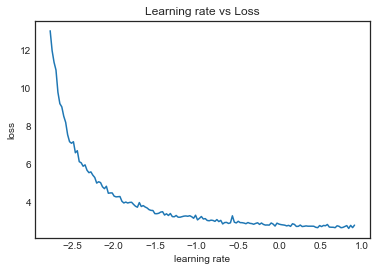

In [11]:
from keras import Model
from keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from compile_keras import compile_keras_model
from clr import LRFinder
from eval_results import eval_results 
from stats_operations import safe_log, safe_exp
from scipy import stats

x_train = remove_cols(df_pp_train_x).values
y_train = all_y

network = {
        'hidden_layers': [7, 7, 7, 7],
        'activation': 'relu',
        'optimizer': 'SGD',
        'kernel_initializer': 'normal',
        'dropout': 0.05,
        'batch_size': 512,
        'model_type': 'mae',
        'int_layer': 30,
    }

num_samples = x_train.shape[0] 
dimensions = x_train.shape[1]

model = compile_keras_model(network, dimensions)

lr_finder = LRFinder(num_samples, network['batch_size'],
                       minimum_lr=1e-3, maximum_lr=10.,
                       # validation_data=(X_val, Y_val),
                       lr_scale='exp', save_dir='./weights/',
                       validation_sample_rate=5, verbose=True)


# Ensure that number of epochs = 1 when calling fit()
model.fit(x_train, 
          safe_log(y_train), 
          epochs=1, 
          batch_size=network['batch_size'], 
          callbacks=[lr_finder])

lr_finder.plot_schedule(clip_beginning=10, clip_endding=5)

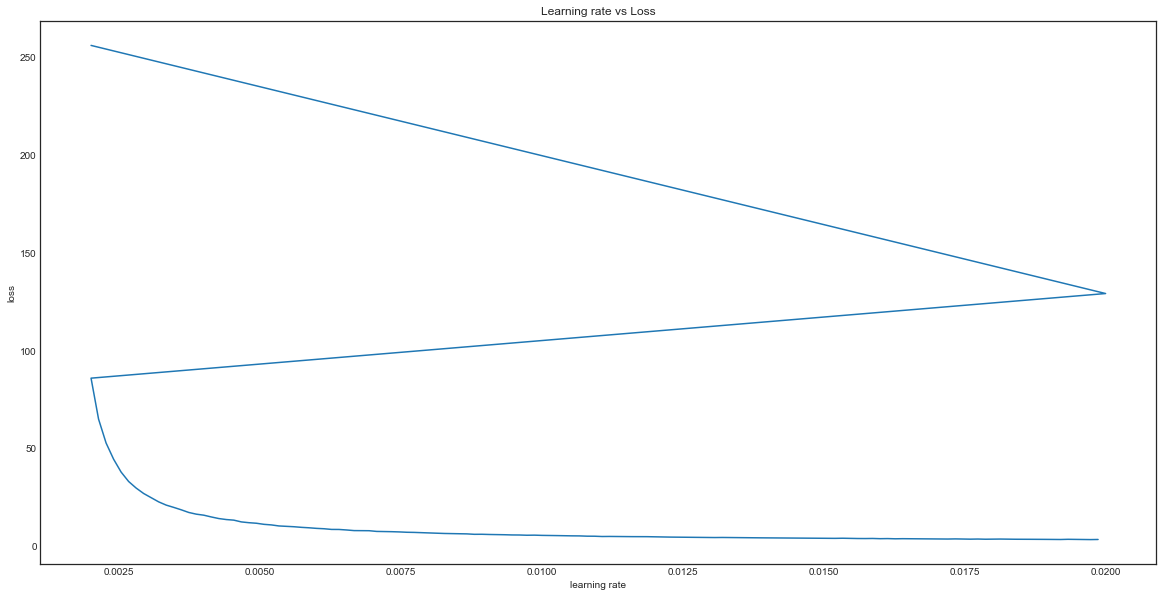

In [91]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(20,10))


plt.plot(lr_finder.lrs, lr_finder.losses)
plt.title('Learning rate vs Loss')
plt.xlabel('learning rate')
plt.ylabel('loss')
plt.show()

In [99]:
%load_ext autoreload
%autoreload 2

from keras import Model
from keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from compile_keras import compile_keras_model
from clr import LRFinder
from eval_results import eval_results 
from stats_operations import safe_log, safe_exp
from scipy import stats

mtrain_mask = df_pp_train_x['round_2']
mtrain_x = remove_cols(df_pp_train_x[mtrain_mask]).values
mtrain_y = all_y[mtrain_mask] #safe_log(all_y[train_mask])
mtest_x = remove_cols(df_pp_train_x[~mtrain_mask]).values
mtest_y = all_y[~mtrain_mask] # safe_log(all_y[~train_mask])

MOMENTUMS = [0.9, 0.95, 0.99]

for momentum in MOMENTUMS:
    network = {
            'hidden_layers': [7, 7, 7, 7],
            'activation': 'relu',
            'optimizer': 'SGD',
            'momentum': momentum,
            'min_lr': 0.002,
            'max_lr': 0.02,
            'kernel_initializer': 'normal',
            'dropout': 0.05,
            'batch_size': 512,
            'model_type': 'mae',
            'int_layer': 30,
        }

    num_samples = mtrain_x.shape[0] 
    dimensions = mtrain_x.shape[1]

    model = compile_keras_model(network, dimensions)

    lr_finder = LRFinder(num_samples, 
                         network['batch_size'],
                         minimum_lr=network['min_lr'], 
                         maximum_lr=network['max_lr'], 
                         validation_data=(mtest_x, mtest_y),
                         lr_scale='linear', 
                         save_dir='./weights/momentum/momentum-%s/' % str(momentum),
                         validation_sample_rate=5, 
                         verbose=True)


    # Ensure that number of epochs = 1 when calling fit()
    model.fit(mtrain_x, 
              mtrain_y, 
              validation_data=(mtest_x, mtest_y),
              epochs=1, 
              batch_size=network['batch_size'], 
              callbacks=[lr_finder])


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Keeping col:  lastTradePriceOnly float32
Keeping col:  adjustedPrice float32
Keeping col:  volume float32
Keeping col:  daysHigh float32
Keeping col:  daysLow float32
Keeping col:  previousClose float32
Keeping col:  change float32
Keeping col:  changeInPercent float32
Keeping col:  52WeekHigh float32
Keeping col:  52WeekLow float32
Keeping col:  changeFrom52WeekHigh float32
Keeping col:  changeFrom52WeekLow float32
Keeping col:  percebtChangeFrom52WeekHigh float32
Keeping col:  percentChangeFrom52WeekLow float32
Keeping col:  allordpreviousclose float32
Keeping col:  allordchange float32
Keeping col:  allorddayshigh float32
Keeping col:  allorddayslow float32
Keeping col:  allordpercebtChangeFrom52WeekHigh float32
Keeping col:  allordpercentChangeFrom52WeekLow float32
Keeping col:  asxpreviousclose float32
Keeping col:  asxchange float32
Keeping col:  asxdayshigh float32
Keeping col:  asxdayslow fl

/Users/neilkloot/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


float32
Keeping col:  eight_week_std float32
Keeping col:  eight_week_bollinger_upper float32
Keeping col:  eight_week_bollinger_lower float32
Keeping col:  eight_week_comparison_adjustedPrice float32
Keeping col:  eight_week_price_change float32
Keeping col:  eight_week_price_return float32
Keeping col:  eight_week_dividend_value float32
Keeping col:  eight_week_dividend_return float32
Keeping col:  eight_week_total_return float32
Keeping col:  twelve_week_min float32
Keeping col:  twelve_week_max float32
Keeping col:  twelve_week_mean float32
Keeping col:  twelve_week_median float32
Keeping col:  twelve_week_std float32
Keeping col:  twelve_week_bollinger_upper float32
Keeping col:  twelve_week_bollinger_lower float32
Keeping col:  twelve_week_comparison_adjustedPrice float32
Keeping col:  twelve_week_price_change float32
Keeping col:  twelve_week_price_return float32
Keeping col:  twelve_week_dividend_value float32
Keeping col:  twelve_week_dividend_return float32
Keeping col:  twel

Keeping col:  twelve_week_median float32
Keeping col:  twelve_week_std float32
Keeping col:  twelve_week_bollinger_upper float32
Keeping col:  twelve_week_bollinger_lower float32
Keeping col:  twelve_week_comparison_adjustedPrice float32
Keeping col:  twelve_week_price_change float32
Keeping col:  twelve_week_price_return float32
Keeping col:  twelve_week_dividend_value float32
Keeping col:  twelve_week_dividend_return float32
Keeping col:  twelve_week_total_return float32
Keeping col:  twenty_six_week_min float32
Keeping col:  twenty_six_week_max float32
Keeping col:  twenty_six_week_mean float32
Keeping col:  twenty_six_week_median float32
Keeping col:  twenty_six_week_std float32
Keeping col:  twenty_six_week_bollinger_upper float32
Keeping col:  twenty_six_week_bollinger_lower float32
Keeping col:  twenty_six_week_comparison_adjustedPrice float32
Keeping col:  twenty_six_week_price_change float32
Keeping col:  twenty_six_week_price_return float32
Keeping col:  twenty_six_week_divid

26112/70798 [==========>...................] - ETA: 23s - loss: 24.8503 - k_mean_absolute_percentage_error: 95.8349 - LRFinder: val_loss: 22.2442 - lr = 0.00715789
Batch begin 52 of 172
26624/70798 [==========>...................] - ETA: 23s - loss: 24.7663 - k_mean_absolute_percentage_error: 95.8319 - LRFinder: val_loss: 23.4896 - lr = 0.00726316
Batch begin 53 of 172
27136/70798 [==========>...................] - ETA: 23s - loss: 24.6767 - k_mean_absolute_percentage_error: 95.8336 - LRFinder: val_loss: 29.8108 - lr = 0.00736842
Batch begin 54 of 172
27648/70798 [==========>...................] - ETA: 23s - loss: 24.6285 - k_mean_absolute_percentage_error: 95.8394 - LRFinder: val_loss: 21.6288 - lr = 0.00747368
Batch begin 55 of 172
28160/70798 [==========>...................] - ETA: 22s - loss: 24.9615 - k_mean_absolute_percentage_error: 95.8438 - LRFinder: val_loss: 29.1259 - lr = 0.00757895
Batch begin 56 of 172
28672/70798 [===========>..................] - ETA: 22s - loss: 24.911

 - LRFinder: val_loss: 24.6161 - lr = 0.01642105
70798/70798 [==============================] - 47s 670us/step - loss: 24.6935 - k_mean_absolute_percentage_error: 96.1686 - val_loss: 24.2004 - val_k_mean_absolute_percentage_error: 99.2237
	LR Finder : Saved the losses and learning rate values in path : {./weights/momentum/momentum-0.9/}
scaled_layers [1764, 1764, 1764, 1764]
Train on 70798 samples, validate on 17543 samples
Epoch 1/1
Batch begin 1 of 172
  512/70798 [..............................] - ETA: 56s - loss: 20.0081 - k_mean_absolute_percentage_error: 95.9144 - LRFinder: val_loss: 27.4803 - lr = 0.02000000
Batch begin 2 of 172
 1024/70798 [..............................] - ETA: 1:03 - loss: 21.7138 - k_mean_absolute_percentage_error: 95.5643 - LRFinder: val_loss: 21.5075 - lr = 0.00200000
Batch begin 3 of 172
 1536/70798 [..............................] - ETA: 1:00 - loss: 23.1897 - k_mean_absolute_percentage_error: 95.7629 - LRFinder: val_loss: 21.4804 - lr = 0.00210526
Batch

44032/70798 [=================>............] - ETA: 21s - loss: 24.9743 - k_mean_absolute_percentage_error: 95.9072 - LRFinder: val_loss: 27.0660 - lr = 0.01084211
Batch begin 87 of 172
44544/70798 [=================>............] - ETA: 21s - loss: 24.9698 - k_mean_absolute_percentage_error: 95.9045 - LRFinder: val_loss: 28.7017 - lr = 0.01094737
Batch begin 88 of 172
45056/70798 [==================>...........] - ETA: 20s - loss: 24.9449 - k_mean_absolute_percentage_error: 95.8950 - LRFinder: val_loss: 25.5011 - lr = 0.01105263
Batch begin 89 of 172
45568/70798 [==================>...........] - ETA: 20s - loss: 24.8885 - k_mean_absolute_percentage_error: 95.8778 - LRFinder: val_loss: 27.5766 - lr = 0.01115789
Batch begin 90 of 172
46080/70798 [==================>...........] - ETA: 19s - loss: 24.9378 - k_mean_absolute_percentage_error: 95.8762 - LRFinder: val_loss: 23.0991 - lr = 0.01126316
Batch begin 91 of 172
46592/70798 [==================>...........] - ETA: 19s - loss: 24.918

66560/70798 [===========================>..] - ETA: 3s - loss: 24.5691 - k_mean_absolute_percentage_error: 95.8539 - LRFinder: val_loss: 21.5941 - lr = 0.01547368
Batch begin 131 of 172
67072/70798 [===========================>..] - ETA: 2s - loss: 24.5619 - k_mean_absolute_percentage_error: 95.8451 - LRFinder: val_loss: 26.6447 - lr = 0.01557895
Batch begin 132 of 172
67584/70798 [===========================>..] - ETA: 2s - loss: 24.5665 - k_mean_absolute_percentage_error: 95.8390 - LRFinder: val_loss: 25.4471 - lr = 0.01568421
Batch begin 133 of 172
68096/70798 [===========================>..] - ETA: 2s - loss: 24.5588 - k_mean_absolute_percentage_error: 95.8366 - LRFinder: val_loss: 22.2825 - lr = 0.01578947
Batch begin 134 of 172
68608/70798 [============================>.] - ETA: 1s - loss: 24.5347 - k_mean_absolute_percentage_error: 95.8375 - LRFinder: val_loss: 21.1295 - lr = 0.01589474
Batch begin 135 of 172
69120/70798 [============================>.] - ETA: 1s - loss: 24.5426

39424/70798 [===============>..............] - ETA: 20s - loss: 25.3742 - k_mean_absolute_percentage_error: 95.2212 - LRFinder: val_loss: 23.1903 - lr = 0.00989474
Batch begin 78 of 172
39936/70798 [===============>..............] - ETA: 19s - loss: 25.5016 - k_mean_absolute_percentage_error: 95.2296 - LRFinder: val_loss: 26.3761 - lr = 0.01000000
Batch begin 79 of 172
40448/70798 [================>.............] - ETA: 19s - loss: 25.4640 - k_mean_absolute_percentage_error: 95.2338 - LRFinder: val_loss: 30.2771 - lr = 0.01010526
Batch begin 80 of 172
40960/70798 [================>.............] - ETA: 19s - loss: 25.6031 - k_mean_absolute_percentage_error: 95.2401 - LRFinder: val_loss: 25.8647 - lr = 0.01021053
Batch begin 81 of 172
41472/70798 [================>.............] - ETA: 18s - loss: 25.5761 - k_mean_absolute_percentage_error: 95.2488 - LRFinder: val_loss: 21.6641 - lr = 0.01031579
Batch begin 82 of 172
41984/70798 [================>.............] - ETA: 18s - loss: 25.542

61952/70798 [=========================>....] - ETA: 5s - loss: 25.0068 - k_mean_absolute_percentage_error: 95.6380 - LRFinder: val_loss: 22.2608 - lr = 0.01452632
Batch begin 122 of 172
62464/70798 [=========================>....] - ETA: 5s - loss: 24.9785 - k_mean_absolute_percentage_error: 95.6525 - LRFinder: val_loss: 23.0250 - lr = 0.01463158
Batch begin 123 of 172
62976/70798 [=========================>....] - ETA: 5s - loss: 24.9370 - k_mean_absolute_percentage_error: 95.6500 - LRFinder: val_loss: 24.5681 - lr = 0.01473684
Batch begin 124 of 172
63488/70798 [=========================>....] - ETA: 4s - loss: 24.9631 - k_mean_absolute_percentage_error: 95.6667 - LRFinder: val_loss: 21.8572 - lr = 0.01484211
Batch begin 125 of 172
64000/70798 [==========================>...] - ETA: 4s - loss: 24.9256 - k_mean_absolute_percentage_error: 95.6735 - LRFinder: val_loss: 21.3355 - lr = 0.01494737
Batch begin 126 of 172
64512/70798 [==========================>...] - ETA: 4s - loss: 24.8987

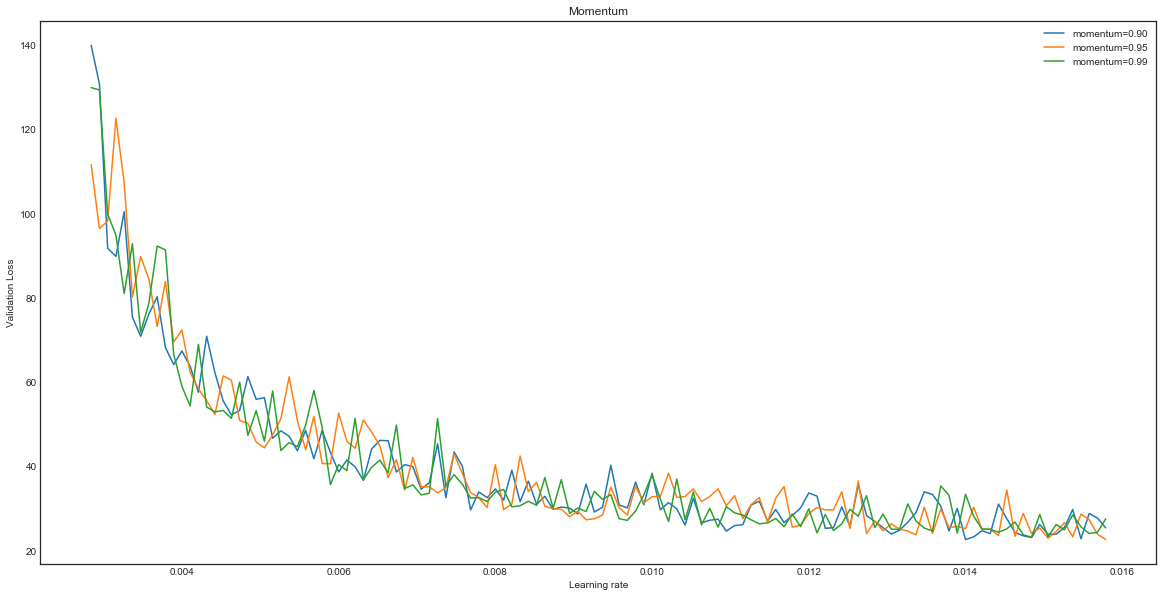

In [100]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(20,10))

for momentum in MOMENTUMS:
    directory = 'weights/momentum/momentum-%s/' % str(momentum)

    losses, lrs = LRFinder.restore_schedule_from_dir(directory, 10, 5)
    plt.plot(lrs, losses, label='momentum=%0.2f' % momentum)

plt.title("Momentum")
plt.xlabel("Learning rate")
plt.ylabel("Validation Loss")
plt.legend()
plt.show()

In [110]:
%load_ext autoreload
%autoreload 2

from keras import Model
from keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from compile_keras import compile_keras_model
from clr import LRFinder
from eval_results import eval_results 
from stats_operations import safe_log, safe_exp
from scipy import stats

wtrain_mask = df_pp_train_x['round_3']
wtrain_x = remove_cols(df_pp_train_x[wtrain_mask]).values
wtrain_y = all_y[wtrain_mask] #safe_log(all_y[train_mask])
wtest_x = remove_cols(df_pp_train_x[~wtrain_mask]).values
wtest_y = all_y[~wtrain_mask] # safe_log(all_y[~train_mask])

# INITIAL WEIGHT DECAY FACTORS
# WEIGHT_DECAY_FACTORS = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7]

# FINEGRAINED WEIGHT DECAY FACTORS
WEIGHT_DECAY_FACTORS = [0.0000005, 0.0000010, 0.0000015, 0.0000020]

for weight_decay in WEIGHT_DECAY_FACTORS:
    network = {
            'hidden_layers': [7, 7, 7, 7],
            'activation': 'relu',
            'optimizer': 'SGD',
            'momentum': 0.9,
            'min_lr': 0.002,
            'max_lr': 0.02,
            'weight_decay': weight_decay,
            'kernel_initializer': 'normal',
            'dropout': 0.05,
            'batch_size': 512,
            'model_type': 'mae',
            'int_layer': 30,
        }

    num_samples = wtrain_x.shape[0] 
    dimensions = wtrain_x.shape[1]

    model = compile_keras_model(network, dimensions)

    lr_finder = LRFinder(num_samples, 
                         network['batch_size'],
                         minimum_lr=network['min_lr'], 
                         maximum_lr=network['max_lr'], 
                         validation_data=(wtest_x, wtest_y),
                         lr_scale='linear',
                         save_dir='./weights/weight_decay/weight_decay-%s/' % str(weight_decay),
                         validation_sample_rate=5, 
                         verbose=True)


    # Ensure that number of epochs = 1 when calling fit()
    model.fit(wtrain_x, 
              wtrain_y, 
              validation_data=(wtest_x, wtest_y),
              epochs=1, 
              batch_size=network['batch_size'], 
              callbacks=[lr_finder])


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Keeping col:  lastTradePriceOnly float32
Keeping col:  adjustedPrice float32
Keeping col:  volume float32
Keeping col:  daysHigh float32
Keeping col:  daysLow float32
Keeping col:  previousClose float32
Keeping col:  change float32
Keeping col:  changeInPercent float32
Keeping col:  52WeekHigh float32
Keeping col:  52WeekLow float32
Keeping col:  changeFrom52WeekHigh float32
Keeping col:  changeFrom52WeekLow float32
Keeping col:  percebtChangeFrom52WeekHigh float32
Keeping col:  percentChangeFrom52WeekLow float32
Keeping col:  allordpreviousclose float32
Keeping col:  allordchange float32
Keeping col:  allorddayshigh float32
Keeping col:  allorddayslow float32
Keeping col:  allordpercebtChangeFrom52WeekHigh float32
Keeping col:  allordpercentChangeFrom52WeekLow float32
Keeping col:  asxpreviousclose float32
Keeping col:  asxchange float32
Keeping col:  asxdayshigh float32
Keeping col:  asxdayslow fl

Keeping col:  PE float32
Keeping col:  QuoteLast float32
Keeping col:  ReturnOnEquityYear float32
Keeping col:  TotalDebtToEquityYear float32
Keeping col:  one_week_min float32
Keeping col:  one_week_max float32
Keeping col:  one_week_mean float32
Keeping col:  one_week_median float32
Keeping col:  one_week_std float32
Keeping col:  one_week_bollinger_upper float32
Keeping col:  one_week_bollinger_lower float32
Keeping col:  one_week_comparison_adjustedPrice float32
Keeping col:  one_week_price_change float32
Keeping col:  one_week_price_return float32
Keeping col:  one_week_dividend_value float32
Keeping col:  one_week_dividend_return float32
Keeping col:  one_week_total_return float32
Keeping col:  two_week_min float32
Keeping col:  two_week_max float32
Keeping col:  two_week_mean float32
Keeping col:  two_week_median float32
Keeping col:  two_week_std float32
Keeping col:  two_week_bollinger_upper float32
Keeping col:  two_week_bollinger_lower float32
Keeping col:  two_week_comparis

Train on 70786 samples, validate on 17555 samples
Epoch 1/1
Batch begin 1 of 138
  512/70786 [..............................] - ETA: 1:02 - loss: 20.9752 - k_mean_absolute_percentage_error: 96.8206 - LRFinder: val_loss: 24.8453 - lr = 0.02000000
Batch begin 2 of 138
 1024/70786 [..............................] - ETA: 1:08 - loss: 20.5597 - k_mean_absolute_percentage_error: 95.8037 - LRFinder: val_loss: 27.7487 - lr = 0.00200000
Batch begin 3 of 138
 1536/70786 [..............................] - ETA: 59s - loss: 21.4769 - k_mean_absolute_percentage_error: 95.8772  - LRFinder: val_loss: 29.0223 - lr = 0.00213139
Batch begin 4 of 138
 2048/70786 [..............................] - ETA: 54s - loss: 21.3221 - k_mean_absolute_percentage_error: 96.1878 - LRFinder: val_loss: 22.6129 - lr = 0.00226277
Batch begin 5 of 138
 2560/70786 [>.............................] - ETA: 51s - loss: 22.1417 - k_mean_absolute_percentage_error: 96.3201 - LRFinder: val_loss: 28.5776 - lr = 0.00239416
Batch begin 

23040/70786 [========>.....................] - ETA: 30s - loss: 23.7109 - k_mean_absolute_percentage_error: 98.7669 - LRFinder: val_loss: 23.7618 - lr = 0.00764964
Batch begin 46 of 138
23552/70786 [========>.....................] - ETA: 29s - loss: 23.6438 - k_mean_absolute_percentage_error: 98.7523 - LRFinder: val_loss: 21.7786 - lr = 0.00778102
Batch begin 47 of 138
24064/70786 [=========>....................] - ETA: 29s - loss: 23.9837 - k_mean_absolute_percentage_error: 98.7439 - LRFinder: val_loss: 22.5161 - lr = 0.00791241
Batch begin 48 of 138
24576/70786 [=========>....................] - ETA: 29s - loss: 23.9223 - k_mean_absolute_percentage_error: 98.7173 - LRFinder: val_loss: 23.5824 - lr = 0.00804380
Batch begin 49 of 138
25088/70786 [=========>....................] - ETA: 29s - loss: 23.9382 - k_mean_absolute_percentage_error: 98.6858 - LRFinder: val_loss: 21.2840 - lr = 0.00817518
Batch begin 50 of 138
25600/70786 [=========>....................] - ETA: 28s - loss: 23.918

68096/70786 [===========================>..] - ETA: 1s - loss: 24.2381 - k_mean_absolute_percentage_error: 103.5925 - LRFinder: val_loss: 22.7754 - lr = 0.01921168
Batch begin 134 of 138
68608/70786 [============================>.] - ETA: 1s - loss: 24.2257 - k_mean_absolute_percentage_error: 103.5818 - LRFinder: val_loss: 23.9071 - lr = 0.01934307
Batch begin 135 of 138
69120/70786 [============================>.] - ETA: 1s - loss: 24.4758 - k_mean_absolute_percentage_error: 103.6828 - LRFinder: val_loss: 22.9767 - lr = 0.01947445
Batch begin 136 of 138
69632/70786 [============================>.] - ETA: 0s - loss: 24.4520 - k_mean_absolute_percentage_error: 103.7399 - LRFinder: val_loss: 24.8908 - lr = 0.01960584
Batch begin 137 of 138
70144/70786 [============================>.] - ETA: 0s - loss: 24.4151 - k_mean_absolute_percentage_error: 103.9761 - LRFinder: val_loss: 30.0842 - lr = 0.01973723
Batch begin 138 of 138
70656/70786 [============================>.] - ETA: 0s - loss: 24

40960/70786 [================>.............] - ETA: 20s - loss: 24.1447 - k_mean_absolute_percentage_error: 99.1053 - LRFinder: val_loss: 20.3125 - lr = 0.01224818
Batch begin 81 of 138
41472/70786 [================>.............] - ETA: 19s - loss: 24.0952 - k_mean_absolute_percentage_error: 99.1257 - LRFinder: val_loss: 20.7466 - lr = 0.01237956
Batch begin 82 of 138
41984/70786 [================>.............] - ETA: 19s - loss: 24.1161 - k_mean_absolute_percentage_error: 99.3237 - LRFinder: val_loss: 21.9886 - lr = 0.01251095
Batch begin 83 of 138
42496/70786 [=================>............] - ETA: 19s - loss: 24.5553 - k_mean_absolute_percentage_error: 99.4643 - LRFinder: val_loss: 24.7924 - lr = 0.01264234
Batch begin 84 of 138
43008/70786 [=================>............] - ETA: 18s - loss: 24.5100 - k_mean_absolute_percentage_error: 99.5693 - LRFinder: val_loss: 29.0799 - lr = 0.01277372
Batch begin 85 of 138
43520/70786 [=================>............] - ETA: 18s - loss: 24.469

63488/70786 [=========================>....] - ETA: 4s - loss: 24.3854 - k_mean_absolute_percentage_error: 104.1117 - LRFinder: val_loss: 25.0721 - lr = 0.01802920
Batch begin 125 of 138
64000/70786 [==========================>...] - ETA: 4s - loss: 24.3707 - k_mean_absolute_percentage_error: 104.2128 - LRFinder: val_loss: 22.9466 - lr = 0.01816058
Batch begin 126 of 138
64512/70786 [==========================>...] - ETA: 4s - loss: 24.3597 - k_mean_absolute_percentage_error: 104.2650 - LRFinder: val_loss: 24.9324 - lr = 0.01829197
Batch begin 127 of 138
65024/70786 [==========================>...] - ETA: 3s - loss: 24.3546 - k_mean_absolute_percentage_error: 104.2748 - LRFinder: val_loss: 24.5842 - lr = 0.01842336
Batch begin 128 of 138
65536/70786 [==========================>...] - ETA: 3s - loss: 24.3423 - k_mean_absolute_percentage_error: 104.2543 - LRFinder: val_loss: 21.6847 - lr = 0.01855474
Batch begin 129 of 138
66048/70786 [==========================>...] - ETA: 3s - loss: 24

36352/70786 [==============>...............] - ETA: 23s - loss: 25.3097 - k_mean_absolute_percentage_error: 96.7987 - LRFinder: val_loss: 31.5693 - lr = 0.01106569
Batch begin 72 of 138
36864/70786 [==============>...............] - ETA: 22s - loss: 25.3052 - k_mean_absolute_percentage_error: 96.8330 - LRFinder: val_loss: 21.6491 - lr = 0.01119708
Batch begin 73 of 138
37376/70786 [==============>...............] - ETA: 22s - loss: 25.2745 - k_mean_absolute_percentage_error: 97.0177 - LRFinder: val_loss: 22.3004 - lr = 0.01132847
Batch begin 74 of 138
37888/70786 [===============>..............] - ETA: 22s - loss: 25.2394 - k_mean_absolute_percentage_error: 97.0924 - LRFinder: val_loss: 21.1655 - lr = 0.01145985
Batch begin 75 of 138
38400/70786 [===============>..............] - ETA: 21s - loss: 25.2420 - k_mean_absolute_percentage_error: 97.2306 - LRFinder: val_loss: 21.2041 - lr = 0.01159124
Batch begin 76 of 138
38912/70786 [===============>..............] - ETA: 21s - loss: 25.208

58880/70786 [=======================>......] - ETA: 8s - loss: 24.7190 - k_mean_absolute_percentage_error: 102.3334 - LRFinder: val_loss: 24.1348 - lr = 0.01684672
Batch begin 116 of 138
59392/70786 [========================>.....] - ETA: 7s - loss: 24.6785 - k_mean_absolute_percentage_error: 102.3783 - LRFinder: val_loss: 24.7361 - lr = 0.01697810
Batch begin 117 of 138
59904/70786 [========================>.....] - ETA: 7s - loss: 24.6530 - k_mean_absolute_percentage_error: 102.5734 - LRFinder: val_loss: 30.2930 - lr = 0.01710949
Batch begin 118 of 138
60416/70786 [========================>.....] - ETA: 6s - loss: 24.6334 - k_mean_absolute_percentage_error: 102.7121 - LRFinder: val_loss: 22.3290 - lr = 0.01724088
Batch begin 119 of 138
60928/70786 [========================>.....] - ETA: 6s - loss: 24.6739 - k_mean_absolute_percentage_error: 102.8623 - LRFinder: val_loss: 28.7659 - lr = 0.01737226
Batch begin 120 of 138
61440/70786 [=========================>....] - ETA: 6s - loss: 24

31744/70786 [============>.................] - ETA: 25s - loss: 23.8773 - k_mean_absolute_percentage_error: 96.4710 - LRFinder: val_loss: 29.5184 - lr = 0.00988321
Batch begin 63 of 138
32256/70786 [============>.................] - ETA: 25s - loss: 23.9271 - k_mean_absolute_percentage_error: 96.4854 - LRFinder: val_loss: 28.2031 - lr = 0.01001460
Batch begin 64 of 138
32768/70786 [============>.................] - ETA: 25s - loss: 23.8746 - k_mean_absolute_percentage_error: 96.5666 - LRFinder: val_loss: 27.3452 - lr = 0.01014599
Batch begin 65 of 138
33280/70786 [=============>................] - ETA: 24s - loss: 23.8465 - k_mean_absolute_percentage_error: 96.7236 - LRFinder: val_loss: 21.1264 - lr = 0.01027737
Batch begin 66 of 138
33792/70786 [=============>................] - ETA: 24s - loss: 23.8021 - k_mean_absolute_percentage_error: 96.8179 - LRFinder: val_loss: 26.1939 - lr = 0.01040876
Batch begin 67 of 138
34304/70786 [=============>................] - ETA: 24s - loss: 23.803

54272/70786 [======================>.......] - ETA: 10s - loss: 24.5469 - k_mean_absolute_percentage_error: 101.8246 - LRFinder: val_loss: 22.7830 - lr = 0.01566423
Batch begin 107 of 138
54784/70786 [======================>.......] - ETA: 10s - loss: 24.9319 - k_mean_absolute_percentage_error: 101.8512 - LRFinder: val_loss: 36.0010 - lr = 0.01579562
Batch begin 108 of 138
55296/70786 [======================>.......] - ETA: 10s - loss: 24.8851 - k_mean_absolute_percentage_error: 101.9600 - LRFinder: val_loss: 21.7330 - lr = 0.01592701
Batch begin 109 of 138
55808/70786 [======================>.......] - ETA: 9s - loss: 24.8472 - k_mean_absolute_percentage_error: 102.0365  - LRFinder: val_loss: 25.0366 - lr = 0.01605839
Batch begin 110 of 138
56320/70786 [======================>.......] - ETA: 9s - loss: 24.8091 - k_mean_absolute_percentage_error: 102.0998 - LRFinder: val_loss: 22.3422 - lr = 0.01618978
Batch begin 111 of 138
56832/70786 [=======================>......] - ETA: 9s - loss

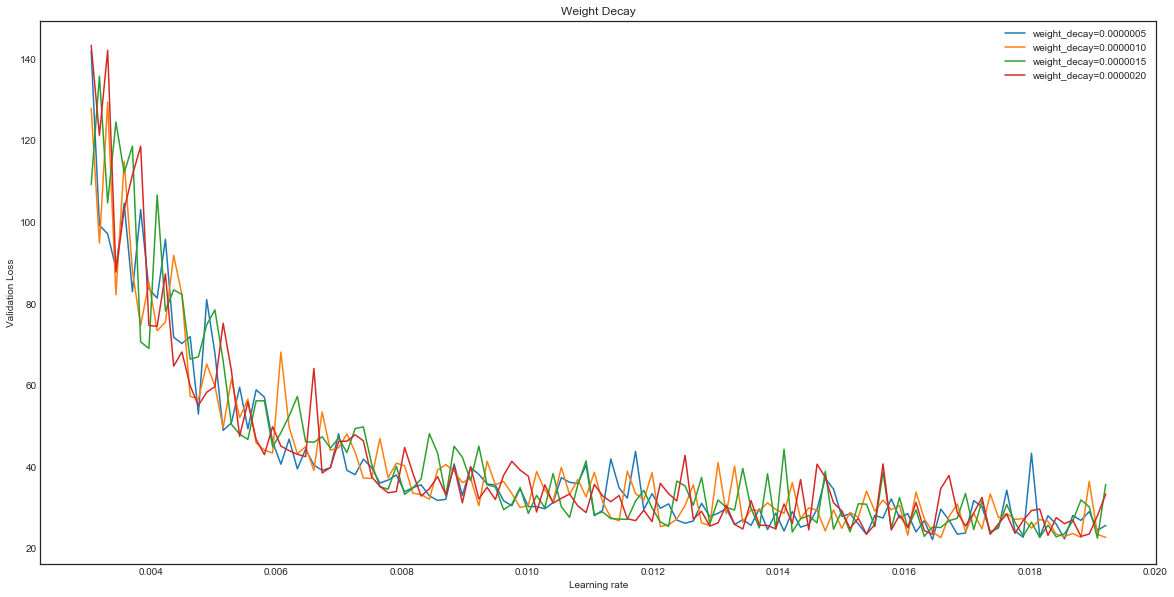

In [111]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(20,10))

for weight_decay in WEIGHT_DECAY_FACTORS:
    directory = 'weights/weight_decay/weight_decay-%s/' % str(weight_decay)

    losses, lrs = LRFinder.restore_schedule_from_dir(directory, 10, 5)
    plt.plot(lrs, losses, label='weight_decay=%0.7f' % weight_decay)

plt.title("Weight Decay")
plt.xlabel("Learning rate")
plt.ylabel("Validation Loss")
plt.legend()
plt.show()

## Deep learning

In [116]:
def results_avg(results):
#     Loop through result dict and get keys
    keys = []
    for key in results[0].keys():
#         print(key)
        vals = []
        
        for result in results:
#             print(result[key])
            vals.append(result[key])

        print(key, ':', np.mean(vals))    
        


In [119]:
from keras import Model
from keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from compile_keras import compile_keras_model
from eval_results import eval_results 
from stats_operations import safe_log, safe_exp
from scipy import stats

# chosen LR = .01 - .03 -> 0.2
from clr import OneCycleLR



def train_nn_one_cycle(x_train, y_train, x_test, y_test):

    network = {
            'hidden_layers': [7, 7, 7, 7],
            'activation': 'relu',
            'optimizer': 'SGD',
            'kernel_initializer': 'normal',
            'momentum': 0.9,
            'min_lr': 0.002,
            'max_lr': 0.02,
            'weight_decay': 0.0000020,
            'dropout': 0.05,
            'batch_size': 512,
            'model_type': 'mae',
            'int_layer': 30,
        }

    num_samples = x_train.shape[0]
    dimensions = x_train.shape[1]
    num_epochs = 1000

    model = compile_keras_model(network, dimensions)

    early_stopping = EarlyStopping(monitor='val_loss', patience=30)
    csv_logger = CSVLogger('./logs/nn-training-log.log')
    checkpointer = ModelCheckpoint(
        filepath='./weights/nn-weights.hdf5', verbose=0, save_best_only=True)

    print('Training keras mae model...')

    # Reorder array - get array index
    array_index = np.arange(x_train.shape[0])

    lr_manager = OneCycleLR(num_samples, 
                            num_epochs, 
                            network['batch_size'], 
                            network['max_lr'],
#                             end_percentage=0.1, 
#                             maximum_momentum=0.95, 
#                             minimum_momentum=0.85,
                            verbose=True)

    # Reshuffle index
    np.random.shuffle(array_index)

    # Create array using new index
    x_shuffled_train = x_train[array_index]
    y_shuffled_train = safe_log(y_train[array_index])
    

    # history = model.fit(x_shuffled_train,
    model.fit(x_shuffled_train,
              y_shuffled_train,
              validation_split=0.15,
              epochs=num_epochs,
              batch_size=network['batch_size'],
              callbacks=[early_stopping, checkpointer, csv_logger, lr_manager],
              verbose=True)

    model.load_weights('./weights/nn-weights.hdf5')

    print('Executing keras predictions...')

    log_y_predictions = model.predict(x_test)
    exp_predictions = safe_exp(log_y_predictions)

    pred_result = eval_results({'keras_log_y': {
            'actual_y': y_test,
            'y_predict': exp_predictions
            }
        })
    
    return pred_result['keras_log_y']

In [120]:
from scipy import stats
results = []

for round_name in round_cols:
    # Get x, y train / test for this round    
    train_mask = df_pp_train_x[round_name]
    train_x = remove_cols(df_pp_train_x[train_mask]).values
    train_y = all_y[train_mask]
    test_x = remove_cols(df_pp_train_x[~train_mask]).values
    test_y = all_y[~train_mask]
          
    # Run model with data removing the round test / train values
    round_result = train_nn_one_cycle(train_x, train_y, test_x, test_y) 
    print(round_name, 'result:', round_result)        
    results.append(round_result)
    
print('Average results')
print('-'*40)
results_avg(results)

Keeping col:  lastTradePriceOnly float32
Keeping col:  adjustedPrice float32
Keeping col:  volume float32
Keeping col:  daysHigh float32
Keeping col:  daysLow float32
Keeping col:  previousClose float32
Keeping col:  change float32
Keeping col:  changeInPercent float32
Keeping col:  52WeekHigh float32
Keeping col:  52WeekLow float32
Keeping col:  changeFrom52WeekHigh float32
Keeping col:  changeFrom52WeekLow float32
Keeping col:  percebtChangeFrom52WeekHigh float32
Keeping col:  percentChangeFrom52WeekLow float32
Keeping col:  allordpreviousclose float32
Keeping col:  allordchange float32
Keeping col:  allorddayshigh float32
Keeping col:  allorddayslow float32
Keeping col:  allordpercebtChangeFrom52WeekHigh float32
Keeping col:  allordpercentChangeFrom52WeekLow float32
Keeping col:  asxpreviousclose float32
Keeping col:  asxchange float32
Keeping col:  asxdayshigh float32
Keeping col:  asxdayslow float32
Keeping col:  asxpercebtChangeFrom52WeekHigh float32
Keeping col:  asxpercentChang

/Users/neilkloot/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)



Keeping col:  twelve_week_max float32
Keeping col:  twelve_week_mean float32
Keeping col:  twelve_week_median float32
Keeping col:  twelve_week_std float32
Keeping col:  twelve_week_bollinger_upper float32
Keeping col:  twelve_week_bollinger_lower float32
Keeping col:  twelve_week_comparison_adjustedPrice float32
Keeping col:  twelve_week_price_change float32
Keeping col:  twelve_week_price_return float32
Keeping col:  twelve_week_dividend_value float32
Keeping col:  twelve_week_dividend_return float32
Keeping col:  twelve_week_total_return float32
Keeping col:  twenty_six_week_min float32
Keeping col:  twenty_six_week_max float32
Keeping col:  twenty_six_week_mean float32
Keeping col:  twenty_six_week_median float32
Keeping col:  twenty_six_week_std float32
Keeping col:  twenty_six_week_bollinger_upper float32
Keeping col:  twenty_six_week_bollinger_lower float32
Keeping col:  twenty_six_week_comparison_adjustedPrice float32
Keeping col:  twenty_six_week_price_change float32
Keeping 

Keeping col:  eight_week_mean float32
Keeping col:  eight_week_median float32
Keeping col:  eight_week_std float32
Keeping col:  eight_week_bollinger_upper float32
Keeping col:  eight_week_bollinger_lower float32
Keeping col:  eight_week_comparison_adjustedPrice float32
Keeping col:  eight_week_price_change float32
Keeping col:  eight_week_price_return float32
Keeping col:  eight_week_dividend_value float32
Keeping col:  eight_week_dividend_return float32
Keeping col:  eight_week_total_return float32
Keeping col:  twelve_week_min float32
Keeping col:  twelve_week_max float32
Keeping col:  twelve_week_mean float32
Keeping col:  twelve_week_median float32
Keeping col:  twelve_week_std float32
Keeping col:  twelve_week_bollinger_upper float32
Keeping col:  twelve_week_bollinger_lower float32
Keeping col:  twelve_week_comparison_adjustedPrice float32
Keeping col:  twelve_week_price_change float32
Keeping col:  twelve_week_price_return float32
Keeping col:  twelve_week_dividend_value float3

/Users/neilkloot/anaconda/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151322). Check your callbacks.
  % delta_t_median)


60104/60104 [==============================] - 17s 285us/step - loss: 2.5689 - k_mean_absolute_percentage_error: 94.7792 - val_loss: 2.5142 - val_k_mean_absolute_percentage_error: 97.3346
 - lr: 0.00203 - momentum: 0.95 
Epoch 2/1000
60104/60104 [==============================] - 18s 293us/step - loss: 2.4774 - k_mean_absolute_percentage_error: 94.9966 - val_loss: 2.4064 - val_k_mean_absolute_percentage_error: 93.2577
 - lr: 0.00207 - momentum: 0.95 
Epoch 3/1000
60104/60104 [==============================] - 18s 300us/step - loss: 2.4317 - k_mean_absolute_percentage_error: 94.4959 - val_loss: 2.4000 - val_k_mean_absolute_percentage_error: 96.4214
 - lr: 0.00210 - momentum: 0.95 
Epoch 4/1000
60104/60104 [==============================] - 19s 322us/step - loss: 2.4155 - k_mean_absolute_percentage_error: 94.5320 - val_loss: 2.3598 - val_k_mean_absolute_percentage_error: 92.5515
 - lr: 0.00214 - momentum: 0.95 
Epoch 5/1000
60104/60104 [==============================] - 19s 319us/step - 

60104/60104 [==============================] - 19s 310us/step - loss: 2.2523 - k_mean_absolute_percentage_error: 90.9391 - val_loss: 2.2371 - val_k_mean_absolute_percentage_error: 91.4658
 - lr: 0.00323 - momentum: 0.94 
Epoch 37/1000
60104/60104 [==============================] - 19s 312us/step - loss: 2.2534 - k_mean_absolute_percentage_error: 90.9851 - val_loss: 2.2451 - val_k_mean_absolute_percentage_error: 90.3849
 - lr: 0.00327 - momentum: 0.94 
Epoch 38/1000
60104/60104 [==============================] - 18s 308us/step - loss: 2.2396 - k_mean_absolute_percentage_error: 90.5664 - val_loss: 2.2882 - val_k_mean_absolute_percentage_error: 94.1440
 - lr: 0.00330 - momentum: 0.94 
Epoch 39/1000
60104/60104 [==============================] - 19s 312us/step - loss: 2.2400 - k_mean_absolute_percentage_error: 90.6365 - val_loss: 2.2497 - val_k_mean_absolute_percentage_error: 90.9241
 - lr: 0.00333 - momentum: 0.94 
Epoch 40/1000
60104/60104 [==============================] - 19s 311us/ste

60104/60104 [==============================] - 19s 312us/step - loss: 2.1641 - k_mean_absolute_percentage_error: 88.5214 - val_loss: 2.1750 - val_k_mean_absolute_percentage_error: 89.5934
 - lr: 0.00443 - momentum: 0.94 
Epoch 72/1000
60104/60104 [==============================] - 19s 310us/step - loss: 2.1641 - k_mean_absolute_percentage_error: 88.4453 - val_loss: 2.1787 - val_k_mean_absolute_percentage_error: 88.6101
 - lr: 0.00446 - momentum: 0.94 
Epoch 73/1000
60104/60104 [==============================] - 19s 311us/step - loss: 2.1581 - k_mean_absolute_percentage_error: 88.2805 - val_loss: 2.1962 - val_k_mean_absolute_percentage_error: 88.9575
 - lr: 0.00450 - momentum: 0.94 
Epoch 74/1000
60104/60104 [==============================] - 19s 310us/step - loss: 2.1573 - k_mean_absolute_percentage_error: 88.2522 - val_loss: 2.1785 - val_k_mean_absolute_percentage_error: 88.3052
 - lr: 0.00453 - momentum: 0.94 
Epoch 75/1000
60104/60104 [==============================] - 19s 313us/ste

60104/60104 [==============================] - 22s 360us/step - loss: 2.0870 - k_mean_absolute_percentage_error: 86.1084 - val_loss: 2.1827 - val_k_mean_absolute_percentage_error: 92.5111
 - lr: 0.00563 - momentum: 0.93 
Epoch 107/1000
60104/60104 [==============================] - 21s 355us/step - loss: 2.0919 - k_mean_absolute_percentage_error: 86.4215 - val_loss: 2.1362 - val_k_mean_absolute_percentage_error: 88.9742
 - lr: 0.00566 - momentum: 0.93 
Epoch 108/1000
60104/60104 [==============================] - 22s 360us/step - loss: 2.0836 - k_mean_absolute_percentage_error: 86.0685 - val_loss: 2.1220 - val_k_mean_absolute_percentage_error: 88.1735
 - lr: 0.00569 - momentum: 0.93 
Epoch 109/1000
60104/60104 [==============================] - 22s 362us/step - loss: 2.0839 - k_mean_absolute_percentage_error: 86.0912 - val_loss: 2.1433 - val_k_mean_absolute_percentage_error: 87.6225
 - lr: 0.00573 - momentum: 0.93 
Epoch 110/1000
60104/60104 [==============================] - 21s 357us

 - lr: 0.00679 - momentum: 0.92 
Epoch 141/1000
60104/60104 [==============================] - 22s 369us/step - loss: 2.0091 - k_mean_absolute_percentage_error: 83.5769 - val_loss: 2.0811 - val_k_mean_absolute_percentage_error: 86.7049
 - lr: 0.00682 - momentum: 0.92 
Epoch 142/1000
60104/60104 [==============================] - 22s 362us/step - loss: 2.0025 - k_mean_absolute_percentage_error: 83.3212 - val_loss: 2.1039 - val_k_mean_absolute_percentage_error: 88.3923
 - lr: 0.00686 - momentum: 0.92 
Epoch 143/1000
60104/60104 [==============================] - 22s 363us/step - loss: 2.0083 - k_mean_absolute_percentage_error: 83.6945 - val_loss: 2.0876 - val_k_mean_absolute_percentage_error: 87.2831
 - lr: 0.00689 - momentum: 0.92 
Epoch 144/1000
60104/60104 [==============================] - 22s 365us/step - loss: 2.0031 - k_mean_absolute_percentage_error: 83.4131 - val_loss: 2.0650 - val_k_mean_absolute_percentage_error: 86.8966
 - lr: 0.00692 - momentum: 0.92 
Epoch 145/1000
60104/60

 - lr: 0.00799 - momentum: 0.92 
Epoch 176/1000
60104/60104 [==============================] - 22s 361us/step - loss: 1.9201 - k_mean_absolute_percentage_error: 80.5894 - val_loss: 2.0351 - val_k_mean_absolute_percentage_error: 87.2914
 - lr: 0.00802 - momentum: 0.92 
Epoch 177/1000
60104/60104 [==============================] - 22s 364us/step - loss: 1.9135 - k_mean_absolute_percentage_error: 80.3048 - val_loss: 2.0363 - val_k_mean_absolute_percentage_error: 85.9271
 - lr: 0.00805 - momentum: 0.92 
Epoch 178/1000
60104/60104 [==============================] - 22s 366us/step - loss: 1.9138 - k_mean_absolute_percentage_error: 80.4341 - val_loss: 2.0324 - val_k_mean_absolute_percentage_error: 85.7085
 - lr: 0.00809 - momentum: 0.92 
Epoch 179/1000
60104/60104 [==============================] - 22s 362us/step - loss: 1.9112 - k_mean_absolute_percentage_error: 80.4127 - val_loss: 2.0093 - val_k_mean_absolute_percentage_error: 84.7706
 - lr: 0.00812 - momentum: 0.92 
Epoch 180/1000
60104/60

 - lr: 0.00918 - momentum: 0.91 
Epoch 211/1000
60104/60104 [==============================] - 22s 365us/step - loss: 1.8240 - k_mean_absolute_percentage_error: 77.2065 - val_loss: 1.9781 - val_k_mean_absolute_percentage_error: 83.3108
 - lr: 0.00922 - momentum: 0.91 
Epoch 212/1000
60104/60104 [==============================] - 21s 356us/step - loss: 1.8218 - k_mean_absolute_percentage_error: 76.8123 - val_loss: 1.9918 - val_k_mean_absolute_percentage_error: 83.7990
 - lr: 0.00925 - momentum: 0.91 
Epoch 213/1000
60104/60104 [==============================] - 22s 361us/step - loss: 1.8252 - k_mean_absolute_percentage_error: 77.1121 - val_loss: 1.9898 - val_k_mean_absolute_percentage_error: 84.2423
 - lr: 0.00928 - momentum: 0.91 
Epoch 214/1000
60104/60104 [==============================] - 22s 359us/step - loss: 1.8183 - k_mean_absolute_percentage_error: 76.9815 - val_loss: 1.9860 - val_k_mean_absolute_percentage_error: 84.2963
 - lr: 0.00932 - momentum: 0.91 
Epoch 215/1000
60104/60

 - lr: 0.01038 - momentum: 0.90 
Epoch 246/1000
60104/60104 [==============================] - 19s 315us/step - loss: 1.7335 - k_mean_absolute_percentage_error: 73.7106 - val_loss: 1.9331 - val_k_mean_absolute_percentage_error: 83.0934
 - lr: 0.01041 - momentum: 0.90 
Epoch 247/1000
60104/60104 [==============================] - 19s 311us/step - loss: 1.7328 - k_mean_absolute_percentage_error: 73.4696 - val_loss: 1.9279 - val_k_mean_absolute_percentage_error: 82.6477
 - lr: 0.01045 - momentum: 0.90 
Epoch 248/1000
60104/60104 [==============================] - 19s 313us/step - loss: 1.7269 - k_mean_absolute_percentage_error: 73.3878 - val_loss: 1.9520 - val_k_mean_absolute_percentage_error: 83.2763
 - lr: 0.01048 - momentum: 0.90 
Epoch 249/1000
60104/60104 [==============================] - 19s 315us/step - loss: 1.7261 - k_mean_absolute_percentage_error: 73.4227 - val_loss: 1.9596 - val_k_mean_absolute_percentage_error: 83.7202
 - lr: 0.01052 - momentum: 0.90 
Epoch 250/1000
60104/60

 - lr: 0.01158 - momentum: 0.90 
Epoch 281/1000
60104/60104 [==============================] - 19s 314us/step - loss: 1.6453 - k_mean_absolute_percentage_error: 70.2609 - val_loss: 1.9279 - val_k_mean_absolute_percentage_error: 82.9432
 - lr: 0.01161 - momentum: 0.90 
Epoch 282/1000
60104/60104 [==============================] - 19s 311us/step - loss: 1.6447 - k_mean_absolute_percentage_error: 70.3207 - val_loss: 1.9218 - val_k_mean_absolute_percentage_error: 82.1556
 - lr: 0.01164 - momentum: 0.90 
Epoch 283/1000
60104/60104 [==============================] - 19s 312us/step - loss: 1.6430 - k_mean_absolute_percentage_error: 70.1216 - val_loss: 1.9023 - val_k_mean_absolute_percentage_error: 80.8249
 - lr: 0.01168 - momentum: 0.90 
Epoch 284/1000
60104/60104 [==============================] - 19s 317us/step - loss: 1.6395 - k_mean_absolute_percentage_error: 70.0690 - val_loss: 1.9227 - val_k_mean_absolute_percentage_error: 81.7760
 - lr: 0.01171 - momentum: 0.90 
Epoch 285/1000
60104/60

 - lr: 0.01277 - momentum: 0.89 
Epoch 316/1000
60104/60104 [==============================] - 22s 359us/step - loss: 1.5572 - k_mean_absolute_percentage_error: 66.6837 - val_loss: 1.8702 - val_k_mean_absolute_percentage_error: 80.1745
 - lr: 0.01281 - momentum: 0.89 
Epoch 317/1000
60104/60104 [==============================] - 22s 362us/step - loss: 1.5589 - k_mean_absolute_percentage_error: 66.7816 - val_loss: 1.8651 - val_k_mean_absolute_percentage_error: 79.4353
 - lr: 0.01284 - momentum: 0.89 
Epoch 318/1000
60104/60104 [==============================] - 22s 364us/step - loss: 1.5591 - k_mean_absolute_percentage_error: 66.8621 - val_loss: 1.8761 - val_k_mean_absolute_percentage_error: 80.7349
 - lr: 0.01288 - momentum: 0.89 
Epoch 319/1000
60104/60104 [==============================] - 22s 364us/step - loss: 1.5451 - k_mean_absolute_percentage_error: 66.3019 - val_loss: 1.8851 - val_k_mean_absolute_percentage_error: 81.1033
 - lr: 0.01291 - momentum: 0.89 
Epoch 320/1000
60104/60

 - lr: 0.01397 - momentum: 0.88 
Epoch 351/1000
60104/60104 [==============================] - 22s 369us/step - loss: 1.4787 - k_mean_absolute_percentage_error: 63.7809 - val_loss: 1.8559 - val_k_mean_absolute_percentage_error: 79.3365
 - lr: 0.01400 - momentum: 0.88 
Epoch 352/1000
60104/60104 [==============================] - 22s 364us/step - loss: 1.4690 - k_mean_absolute_percentage_error: 63.2124 - val_loss: 1.8626 - val_k_mean_absolute_percentage_error: 79.0421
 - lr: 0.01404 - momentum: 0.88 
Epoch 353/1000
60104/60104 [==============================] - 22s 366us/step - loss: 1.4707 - k_mean_absolute_percentage_error: 63.3158 - val_loss: 1.8531 - val_k_mean_absolute_percentage_error: 79.1873
 - lr: 0.01407 - momentum: 0.88 
Epoch 354/1000
60104/60104 [==============================] - 22s 367us/step - loss: 1.4647 - k_mean_absolute_percentage_error: 63.0960 - val_loss: 1.8506 - val_k_mean_absolute_percentage_error: 79.1301
 - lr: 0.01411 - momentum: 0.88 
Epoch 355/1000
60104/60

 - lr: 0.01517 - momentum: 0.88 
Epoch 386/1000
60104/60104 [==============================] - 22s 366us/step - loss: 1.4082 - k_mean_absolute_percentage_error: 60.7962 - val_loss: 1.8364 - val_k_mean_absolute_percentage_error: 79.7517
 - lr: 0.01520 - momentum: 0.88 
Epoch 387/1000
60104/60104 [==============================] - 22s 365us/step - loss: 1.3954 - k_mean_absolute_percentage_error: 60.2975 - val_loss: 1.8381 - val_k_mean_absolute_percentage_error: 78.9216
 - lr: 0.01524 - momentum: 0.88 
Epoch 388/1000
60104/60104 [==============================] - 22s 363us/step - loss: 1.4060 - k_mean_absolute_percentage_error: 60.7358 - val_loss: 1.8111 - val_k_mean_absolute_percentage_error: 77.5948
 - lr: 0.01527 - momentum: 0.88 
Epoch 389/1000
60104/60104 [==============================] - 22s 363us/step - loss: 1.4016 - k_mean_absolute_percentage_error: 60.4997 - val_loss: 1.8002 - val_k_mean_absolute_percentage_error: 77.5768
 - lr: 0.01530 - momentum: 0.88 
Epoch 390/1000
60104/60

 - lr: 0.01636 - momentum: 0.87 
Epoch 421/1000
60104/60104 [==============================] - 22s 364us/step - loss: 1.3329 - k_mean_absolute_percentage_error: 57.7151 - val_loss: 1.8216 - val_k_mean_absolute_percentage_error: 78.8293
 - lr: 0.01640 - momentum: 0.87 
Epoch 422/1000
60104/60104 [==============================] - 22s 364us/step - loss: 1.3344 - k_mean_absolute_percentage_error: 57.8778 - val_loss: 1.8226 - val_k_mean_absolute_percentage_error: 78.1462
 - lr: 0.01643 - momentum: 0.87 
Epoch 423/1000
60104/60104 [==============================] - 22s 362us/step - loss: 1.3331 - k_mean_absolute_percentage_error: 57.6592 - val_loss: 1.8275 - val_k_mean_absolute_percentage_error: 79.4910
 - lr: 0.01647 - momentum: 0.87 
Epoch 424/1000
60104/60104 [==============================] - 22s 363us/step - loss: 1.3281 - k_mean_absolute_percentage_error: 57.4236 - val_loss: 1.7905 - val_k_mean_absolute_percentage_error: 77.9441
 - lr: 0.01650 - momentum: 0.87 
Epoch 425/1000
60104/60

 - lr: 0.01756 - momentum: 0.86 
Epoch 456/1000
60104/60104 [==============================] - 22s 365us/step - loss: 1.2835 - k_mean_absolute_percentage_error: 55.7667 - val_loss: 1.8149 - val_k_mean_absolute_percentage_error: 78.3120
 - lr: 0.01760 - momentum: 0.86 
Epoch 457/1000
60104/60104 [==============================] - 22s 365us/step - loss: 1.2761 - k_mean_absolute_percentage_error: 55.4237 - val_loss: 1.7692 - val_k_mean_absolute_percentage_error: 76.5848
 - lr: 0.01763 - momentum: 0.86 
Epoch 458/1000
60104/60104 [==============================] - 22s 365us/step - loss: 1.2756 - k_mean_absolute_percentage_error: 55.4516 - val_loss: 1.7718 - val_k_mean_absolute_percentage_error: 76.7577
 - lr: 0.01766 - momentum: 0.86 
Epoch 459/1000
60104/60104 [==============================] - 22s 371us/step - loss: 1.2749 - k_mean_absolute_percentage_error: 55.4775 - val_loss: 1.7885 - val_k_mean_absolute_percentage_error: 76.3864
 - lr: 0.01770 - momentum: 0.86 
Epoch 460/1000
60104/60

 - lr: 0.01876 - momentum: 0.86 
Epoch 491/1000
60104/60104 [==============================] - 22s 367us/step - loss: 1.2261 - k_mean_absolute_percentage_error: 53.2498 - val_loss: 1.7604 - val_k_mean_absolute_percentage_error: 75.6442
 - lr: 0.01879 - momentum: 0.86 
Epoch 492/1000
60104/60104 [==============================] - 22s 368us/step - loss: 1.2297 - k_mean_absolute_percentage_error: 53.6161 - val_loss: 1.7768 - val_k_mean_absolute_percentage_error: 76.4886
 - lr: 0.01883 - momentum: 0.86 
Epoch 493/1000
60104/60104 [==============================] - 22s 370us/step - loss: 1.2310 - k_mean_absolute_percentage_error: 53.5450 - val_loss: 1.7654 - val_k_mean_absolute_percentage_error: 76.4315
 - lr: 0.01886 - momentum: 0.86 
Epoch 494/1000
60104/60104 [==============================] - 23s 376us/step - loss: 1.2360 - k_mean_absolute_percentage_error: 53.7409 - val_loss: 1.8206 - val_k_mean_absolute_percentage_error: 78.0960
 - lr: 0.01890 - momentum: 0.86 
Epoch 495/1000
60104/60

Keeping col:  eight_week_price_return float32
Keeping col:  eight_week_dividend_value float32
Keeping col:  eight_week_dividend_return float32
Keeping col:  eight_week_total_return float32
Keeping col:  twelve_week_min float32
Keeping col:  twelve_week_max float32
Keeping col:  twelve_week_mean float32
Keeping col:  twelve_week_median float32
Keeping col:  twelve_week_std float32
Keeping col:  twelve_week_bollinger_upper float32
Keeping col:  twelve_week_bollinger_lower float32
Keeping col:  twelve_week_comparison_adjustedPrice float32
Keeping col:  twelve_week_price_change float32
Keeping col:  twelve_week_price_return float32
Keeping col:  twelve_week_dividend_value float32
Keeping col:  twelve_week_dividend_return float32
Keeping col:  twelve_week_total_return float32
Keeping col:  twenty_six_week_min float32
Keeping col:  twenty_six_week_max float32
Keeping col:  twenty_six_week_mean float32
Keeping col:  twenty_six_week_median float32
Keeping col:  twenty_six_week_std float32
Keep

Keeping col:  TotalDebtToEquityYear float32
Keeping col:  one_week_min float32
Keeping col:  one_week_max float32
Keeping col:  one_week_mean float32
Keeping col:  one_week_median float32
Keeping col:  one_week_std float32
Keeping col:  one_week_bollinger_upper float32
Keeping col:  one_week_bollinger_lower float32
Keeping col:  one_week_comparison_adjustedPrice float32
Keeping col:  one_week_price_change float32
Keeping col:  one_week_price_return float32
Keeping col:  one_week_dividend_value float32
Keeping col:  one_week_dividend_return float32
Keeping col:  one_week_total_return float32
Keeping col:  two_week_min float32
Keeping col:  two_week_max float32
Keeping col:  two_week_mean float32
Keeping col:  two_week_median float32
Keeping col:  two_week_std float32
Keeping col:  two_week_bollinger_upper float32
Keeping col:  two_week_bollinger_lower float32
Keeping col:  two_week_comparison_adjustedPrice float32
Keeping col:  two_week_price_change float32
Keeping col:  two_week_price_

Train on 59980 samples, validate on 10585 samples
Epoch 1/1000
 1536/59980 [..............................] - ETA: 43s - loss: 2.5961 - k_mean_absolute_percentage_error: 94.9150

/Users/neilkloot/anaconda/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161619). Check your callbacks.
  % delta_t_median)


59980/59980 [==============================] - 23s 385us/step - loss: 2.5524 - k_mean_absolute_percentage_error: 95.2499 - val_loss: 2.4704 - val_k_mean_absolute_percentage_error: 94.2955
 - lr: 0.00203 - momentum: 0.95 
Epoch 2/1000
59980/59980 [==============================] - 22s 363us/step - loss: 2.4583 - k_mean_absolute_percentage_error: 94.4309 - val_loss: 2.4100 - val_k_mean_absolute_percentage_error: 93.6423
 - lr: 0.00207 - momentum: 0.95 
Epoch 3/1000
59980/59980 [==============================] - 22s 368us/step - loss: 2.4322 - k_mean_absolute_percentage_error: 94.4959 - val_loss: 2.3907 - val_k_mean_absolute_percentage_error: 93.6182
 - lr: 0.00210 - momentum: 0.95 
Epoch 4/1000
59980/59980 [==============================] - 22s 375us/step - loss: 2.4137 - k_mean_absolute_percentage_error: 94.1235 - val_loss: 2.3809 - val_k_mean_absolute_percentage_error: 94.1661
 - lr: 0.00214 - momentum: 0.95 
Epoch 5/1000
59980/59980 [==============================] - 22s 369us/step - 

59980/59980 [==============================] - 23s 379us/step - loss: 2.2539 - k_mean_absolute_percentage_error: 91.1459 - val_loss: 2.2489 - val_k_mean_absolute_percentage_error: 89.7423
 - lr: 0.00324 - momentum: 0.94 
Epoch 37/1000
59980/59980 [==============================] - 22s 375us/step - loss: 2.2491 - k_mean_absolute_percentage_error: 91.0309 - val_loss: 2.3726 - val_k_mean_absolute_percentage_error: 95.7502
 - lr: 0.00327 - momentum: 0.94 
Epoch 38/1000
59980/59980 [==============================] - 23s 379us/step - loss: 2.2506 - k_mean_absolute_percentage_error: 91.0168 - val_loss: 2.3125 - val_k_mean_absolute_percentage_error: 96.6950
 - lr: 0.00331 - momentum: 0.94 
Epoch 39/1000
59980/59980 [==============================] - 22s 374us/step - loss: 2.2460 - k_mean_absolute_percentage_error: 91.0106 - val_loss: 2.3771 - val_k_mean_absolute_percentage_error: 96.4103
 - lr: 0.00334 - momentum: 0.94 
Epoch 40/1000
59980/59980 [==============================] - 23s 378us/ste

59980/59980 [==============================] - 22s 370us/step - loss: 2.1670 - k_mean_absolute_percentage_error: 88.3776 - val_loss: 2.1974 - val_k_mean_absolute_percentage_error: 88.0043
 - lr: 0.00445 - momentum: 0.94 
Epoch 72/1000
59980/59980 [==============================] - 22s 372us/step - loss: 2.1674 - k_mean_absolute_percentage_error: 88.4065 - val_loss: 2.3577 - val_k_mean_absolute_percentage_error: 99.8265
 - lr: 0.00448 - momentum: 0.94 
Epoch 73/1000
59980/59980 [==============================] - 22s 374us/step - loss: 2.1756 - k_mean_absolute_percentage_error: 88.7314 - val_loss: 2.1872 - val_k_mean_absolute_percentage_error: 89.6136
 - lr: 0.00451 - momentum: 0.94 
Epoch 74/1000
59980/59980 [==============================] - 23s 379us/step - loss: 2.1689 - k_mean_absolute_percentage_error: 88.4196 - val_loss: 2.1790 - val_k_mean_absolute_percentage_error: 88.8504
 - lr: 0.00455 - momentum: 0.94 
Epoch 75/1000
59980/59980 [==============================] - 23s 379us/ste

59980/59980 [==============================] - 22s 373us/step - loss: 2.1012 - k_mean_absolute_percentage_error: 86.4374 - val_loss: 2.1409 - val_k_mean_absolute_percentage_error: 87.8897
 - lr: 0.00565 - momentum: 0.93 
Epoch 107/1000
59980/59980 [==============================] - 22s 373us/step - loss: 2.0952 - k_mean_absolute_percentage_error: 86.2297 - val_loss: 2.1816 - val_k_mean_absolute_percentage_error: 88.3113
 - lr: 0.00569 - momentum: 0.93 
Epoch 108/1000
59980/59980 [==============================] - 22s 363us/step - loss: 2.0935 - k_mean_absolute_percentage_error: 86.1869 - val_loss: 2.1763 - val_k_mean_absolute_percentage_error: 89.4670
 - lr: 0.00572 - momentum: 0.93 
Epoch 109/1000
59980/59980 [==============================] - 22s 369us/step - loss: 2.0932 - k_mean_absolute_percentage_error: 86.0496 - val_loss: 2.1675 - val_k_mean_absolute_percentage_error: 89.5985
 - lr: 0.00576 - momentum: 0.93 
Epoch 110/1000
59980/59980 [==============================] - 22s 370us

 - lr: 0.00682 - momentum: 0.92 
Epoch 141/1000
59980/59980 [==============================] - 22s 372us/step - loss: 2.0189 - k_mean_absolute_percentage_error: 83.6841 - val_loss: 2.1265 - val_k_mean_absolute_percentage_error: 88.2327
 - lr: 0.00686 - momentum: 0.92 
Epoch 142/1000
59980/59980 [==============================] - 22s 369us/step - loss: 2.0165 - k_mean_absolute_percentage_error: 83.6827 - val_loss: 2.0967 - val_k_mean_absolute_percentage_error: 88.0456
 - lr: 0.00689 - momentum: 0.92 
Epoch 143/1000
59980/59980 [==============================] - 22s 369us/step - loss: 2.0140 - k_mean_absolute_percentage_error: 83.8072 - val_loss: 2.0901 - val_k_mean_absolute_percentage_error: 87.7846
 - lr: 0.00693 - momentum: 0.92 
Epoch 144/1000
59980/59980 [==============================] - 22s 367us/step - loss: 2.0069 - k_mean_absolute_percentage_error: 83.4546 - val_loss: 2.1614 - val_k_mean_absolute_percentage_error: 87.9195
 - lr: 0.00696 - momentum: 0.92 
Epoch 145/1000
59980/59

 - lr: 0.00803 - momentum: 0.92 
Epoch 176/1000
59980/59980 [==============================] - 22s 370us/step - loss: 1.9311 - k_mean_absolute_percentage_error: 80.7447 - val_loss: 2.0576 - val_k_mean_absolute_percentage_error: 86.1401
 - lr: 0.00806 - momentum: 0.92 
Epoch 177/1000
59980/59980 [==============================] - 22s 370us/step - loss: 1.9352 - k_mean_absolute_percentage_error: 80.9000 - val_loss: 2.0791 - val_k_mean_absolute_percentage_error: 86.1382
 - lr: 0.00810 - momentum: 0.92 
Epoch 178/1000
59980/59980 [==============================] - 22s 372us/step - loss: 1.9266 - k_mean_absolute_percentage_error: 80.6487 - val_loss: 2.0743 - val_k_mean_absolute_percentage_error: 86.5490
 - lr: 0.00813 - momentum: 0.92 
Epoch 179/1000
59980/59980 [==============================] - 23s 375us/step - loss: 1.9244 - k_mean_absolute_percentage_error: 80.5325 - val_loss: 2.0939 - val_k_mean_absolute_percentage_error: 87.5449
 - lr: 0.00817 - momentum: 0.92 
Epoch 180/1000
59980/59

 - lr: 0.00923 - momentum: 0.91 
Epoch 211/1000
59980/59980 [==============================] - 23s 380us/step - loss: 1.8403 - k_mean_absolute_percentage_error: 77.4315 - val_loss: 2.0468 - val_k_mean_absolute_percentage_error: 86.4619
 - lr: 0.00927 - momentum: 0.91 
Epoch 212/1000
59980/59980 [==============================] - 23s 386us/step - loss: 1.8405 - k_mean_absolute_percentage_error: 77.5068 - val_loss: 2.0204 - val_k_mean_absolute_percentage_error: 83.4258
 - lr: 0.00930 - momentum: 0.91 
Epoch 213/1000
59980/59980 [==============================] - 23s 383us/step - loss: 1.8315 - k_mean_absolute_percentage_error: 77.1550 - val_loss: 2.0086 - val_k_mean_absolute_percentage_error: 84.9964
 - lr: 0.00934 - momentum: 0.91 
Epoch 214/1000
59980/59980 [==============================] - 23s 379us/step - loss: 1.8375 - k_mean_absolute_percentage_error: 77.4112 - val_loss: 2.0560 - val_k_mean_absolute_percentage_error: 85.4093
 - lr: 0.00937 - momentum: 0.91 
Epoch 215/1000
59980/59

 - lr: 0.01044 - momentum: 0.90 
Epoch 246/1000
59980/59980 [==============================] - 22s 373us/step - loss: 1.7501 - k_mean_absolute_percentage_error: 74.2396 - val_loss: 2.0310 - val_k_mean_absolute_percentage_error: 85.6247
 - lr: 0.01048 - momentum: 0.90 
Epoch 247/1000
59980/59980 [==============================] - 23s 382us/step - loss: 1.7544 - k_mean_absolute_percentage_error: 74.4368 - val_loss: 1.9642 - val_k_mean_absolute_percentage_error: 82.4816
 - lr: 0.01051 - momentum: 0.90 
Epoch 248/1000
59980/59980 [==============================] - 22s 373us/step - loss: 1.7478 - k_mean_absolute_percentage_error: 74.0338 - val_loss: 1.9873 - val_k_mean_absolute_percentage_error: 83.9856
 - lr: 0.01054 - momentum: 0.90 
Epoch 249/1000
59980/59980 [==============================] - 23s 377us/step - loss: 1.7452 - k_mean_absolute_percentage_error: 73.9159 - val_loss: 2.0250 - val_k_mean_absolute_percentage_error: 84.2601
 - lr: 0.01058 - momentum: 0.90 
Epoch 250/1000
59980/59

Keeping col:  one_week_bollinger_lower float32
Keeping col:  one_week_comparison_adjustedPrice float32
Keeping col:  one_week_price_change float32
Keeping col:  one_week_price_return float32
Keeping col:  one_week_dividend_value float32
Keeping col:  one_week_dividend_return float32
Keeping col:  one_week_total_return float32
Keeping col:  two_week_min float32
Keeping col:  two_week_max float32
Keeping col:  two_week_mean float32
Keeping col:  two_week_median float32
Keeping col:  two_week_std float32
Keeping col:  two_week_bollinger_upper float32
Keeping col:  two_week_bollinger_lower float32
Keeping col:  two_week_comparison_adjustedPrice float32
Keeping col:  two_week_price_change float32
Keeping col:  two_week_price_return float32
Keeping col:  two_week_dividend_value float32
Keeping col:  two_week_dividend_return float32
Keeping col:  two_week_total_return float32
Keeping col:  four_week_min float32
Keeping col:  four_week_max float32
Keeping col:  four_week_mean float32
Keeping c

Keeping col:  changeFrom52WeekHigh float32
Keeping col:  changeFrom52WeekLow float32
Keeping col:  percebtChangeFrom52WeekHigh float32
Keeping col:  percentChangeFrom52WeekLow float32
Keeping col:  allordpreviousclose float32
Keeping col:  allordchange float32
Keeping col:  allorddayshigh float32
Keeping col:  allorddayslow float32
Keeping col:  allordpercebtChangeFrom52WeekHigh float32
Keeping col:  allordpercentChangeFrom52WeekLow float32
Keeping col:  asxpreviousclose float32
Keeping col:  asxchange float32
Keeping col:  asxdayshigh float32
Keeping col:  asxdayslow float32
Keeping col:  asxpercebtChangeFrom52WeekHigh float32
Keeping col:  asxpercentChangeFrom52WeekLow float32
Keeping col:  exDividendPayout float32
Keeping col:  640106_A3597525W float32
Keeping col:  AINTCOV float32
Keeping col:  Beta float32
Keeping col:  BookValuePerShareYear float32
Keeping col:  CashPerShareYear float32
Keeping col:  DPSRecentYear float32
Keeping col:  EPS float32
Keeping col:  FIRMMCRT float32
K

Train on 60066 samples, validate on 10601 samples
Epoch 1/1000
 1536/60066 [..............................] - ETA: 43s - loss: 2.5981 - k_mean_absolute_percentage_error: 96.4865

/Users/neilkloot/anaconda/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168093). Check your callbacks.
  % delta_t_median)


60066/60066 [==============================] - 23s 389us/step - loss: 2.5720 - k_mean_absolute_percentage_error: 95.2819 - val_loss: 2.5285 - val_k_mean_absolute_percentage_error: 93.8186
 - lr: 0.00203 - momentum: 0.95 
Epoch 2/1000
60066/60066 [==============================] - 22s 365us/step - loss: 2.4927 - k_mean_absolute_percentage_error: 94.8969 - val_loss: 2.4386 - val_k_mean_absolute_percentage_error: 93.9771
 - lr: 0.00207 - momentum: 0.95 
Epoch 3/1000
60066/60066 [==============================] - 23s 375us/step - loss: 2.4472 - k_mean_absolute_percentage_error: 94.5539 - val_loss: 2.4157 - val_k_mean_absolute_percentage_error: 94.8902
 - lr: 0.00210 - momentum: 0.95 
Epoch 4/1000
60066/60066 [==============================] - 23s 376us/step - loss: 2.4220 - k_mean_absolute_percentage_error: 94.3039 - val_loss: 2.3909 - val_k_mean_absolute_percentage_error: 92.3978
 - lr: 0.00214 - momentum: 0.95 
Epoch 5/1000
60066/60066 [==============================] - 23s 381us/step - 

60066/60066 [==============================] - 23s 385us/step - loss: 2.2480 - k_mean_absolute_percentage_error: 90.9385 - val_loss: 2.3652 - val_k_mean_absolute_percentage_error: 100.0133
 - lr: 0.00323 - momentum: 0.94 
Epoch 37/1000
60066/60066 [==============================] - 23s 386us/step - loss: 2.2479 - k_mean_absolute_percentage_error: 91.0021 - val_loss: 2.3370 - val_k_mean_absolute_percentage_error: 94.8371
 - lr: 0.00327 - momentum: 0.94 
Epoch 38/1000
60066/60066 [==============================] - 23s 382us/step - loss: 2.2499 - k_mean_absolute_percentage_error: 91.1028 - val_loss: 2.2936 - val_k_mean_absolute_percentage_error: 91.7665
 - lr: 0.00330 - momentum: 0.94 
Epoch 39/1000
60066/60066 [==============================] - 23s 378us/step - loss: 2.2450 - k_mean_absolute_percentage_error: 90.9177 - val_loss: 2.4244 - val_k_mean_absolute_percentage_error: 97.9543
 - lr: 0.00333 - momentum: 0.94 
Epoch 40/1000
60066/60066 [==============================] - 23s 383us/st

60066/60066 [==============================] - 24s 394us/step - loss: 2.1771 - k_mean_absolute_percentage_error: 89.0070 - val_loss: 2.1890 - val_k_mean_absolute_percentage_error: 89.7460
 - lr: 0.00443 - momentum: 0.94 
Epoch 72/1000
60066/60066 [==============================] - 23s 388us/step - loss: 2.1648 - k_mean_absolute_percentage_error: 88.5987 - val_loss: 2.2415 - val_k_mean_absolute_percentage_error: 92.4316
 - lr: 0.00446 - momentum: 0.94 
Epoch 73/1000
60066/60066 [==============================] - 23s 389us/step - loss: 2.1656 - k_mean_absolute_percentage_error: 88.5327 - val_loss: 2.2090 - val_k_mean_absolute_percentage_error: 89.3810
 - lr: 0.00450 - momentum: 0.94 
Epoch 74/1000
60066/60066 [==============================] - 23s 389us/step - loss: 2.1613 - k_mean_absolute_percentage_error: 88.4628 - val_loss: 2.1979 - val_k_mean_absolute_percentage_error: 88.9431
 - lr: 0.00453 - momentum: 0.94 
Epoch 75/1000
60066/60066 [==============================] - 23s 386us/ste

60066/60066 [==============================] - 23s 385us/step - loss: 2.0957 - k_mean_absolute_percentage_error: 86.4805 - val_loss: 2.1415 - val_k_mean_absolute_percentage_error: 87.1016
 - lr: 0.00563 - momentum: 0.93 
Epoch 107/1000
60066/60066 [==============================] - 23s 389us/step - loss: 2.0882 - k_mean_absolute_percentage_error: 86.1019 - val_loss: 2.1556 - val_k_mean_absolute_percentage_error: 87.7581
 - lr: 0.00566 - momentum: 0.93 
Epoch 108/1000
60066/60066 [==============================] - 23s 385us/step - loss: 2.0918 - k_mean_absolute_percentage_error: 86.4579 - val_loss: 2.1453 - val_k_mean_absolute_percentage_error: 87.5641
 - lr: 0.00569 - momentum: 0.93 
Epoch 109/1000
60066/60066 [==============================] - 23s 389us/step - loss: 2.0871 - k_mean_absolute_percentage_error: 86.1073 - val_loss: 2.1420 - val_k_mean_absolute_percentage_error: 89.4052
 - lr: 0.00573 - momentum: 0.93 
Epoch 110/1000
60066/60066 [==============================] - 23s 388us

 - lr: 0.00679 - momentum: 0.92 
Epoch 141/1000
60066/60066 [==============================] - 23s 391us/step - loss: 2.0195 - k_mean_absolute_percentage_error: 84.0134 - val_loss: 2.0865 - val_k_mean_absolute_percentage_error: 86.5596
 - lr: 0.00682 - momentum: 0.92 
Epoch 142/1000
60066/60066 [==============================] - 24s 393us/step - loss: 2.0102 - k_mean_absolute_percentage_error: 83.6716 - val_loss: 2.1255 - val_k_mean_absolute_percentage_error: 89.6257
 - lr: 0.00686 - momentum: 0.92 
Epoch 143/1000
60066/60066 [==============================] - 24s 392us/step - loss: 2.0054 - k_mean_absolute_percentage_error: 83.3402 - val_loss: 2.1002 - val_k_mean_absolute_percentage_error: 86.9765
 - lr: 0.00689 - momentum: 0.92 
Epoch 144/1000
60066/60066 [==============================] - 23s 390us/step - loss: 2.0082 - k_mean_absolute_percentage_error: 83.6868 - val_loss: 2.1267 - val_k_mean_absolute_percentage_error: 87.6412
 - lr: 0.00692 - momentum: 0.92 
Epoch 145/1000
60066/60

 - lr: 0.00915 - momentum: 0.91 
Epoch 210/1000
60066/60066 [==============================] - 24s 398us/step - loss: 1.8349 - k_mean_absolute_percentage_error: 77.4157 - val_loss: 2.0234 - val_k_mean_absolute_percentage_error: 84.7455
 - lr: 0.00918 - momentum: 0.91 
Epoch 211/1000
60066/60066 [==============================] - 24s 396us/step - loss: 1.8350 - k_mean_absolute_percentage_error: 77.4705 - val_loss: 2.0320 - val_k_mean_absolute_percentage_error: 85.0066
 - lr: 0.00922 - momentum: 0.91 
Epoch 212/1000
60066/60066 [==============================] - 24s 392us/step - loss: 1.8305 - k_mean_absolute_percentage_error: 77.0873 - val_loss: 2.0186 - val_k_mean_absolute_percentage_error: 85.0860
 - lr: 0.00925 - momentum: 0.91 
Epoch 213/1000
60066/60066 [==============================] - 23s 390us/step - loss: 1.8364 - k_mean_absolute_percentage_error: 77.4092 - val_loss: 2.0052 - val_k_mean_absolute_percentage_error: 84.0427
 - lr: 0.00928 - momentum: 0.91 
Epoch 214/1000
60066/60

 - lr: 0.01035 - momentum: 0.90 
Epoch 245/1000
60066/60066 [==============================] - 24s 398us/step - loss: 1.7371 - k_mean_absolute_percentage_error: 73.7945 - val_loss: 1.9882 - val_k_mean_absolute_percentage_error: 84.0042
 - lr: 0.01038 - momentum: 0.90 
Epoch 246/1000
60066/60066 [==============================] - 24s 404us/step - loss: 1.7374 - k_mean_absolute_percentage_error: 73.8059 - val_loss: 1.9612 - val_k_mean_absolute_percentage_error: 82.7176
 - lr: 0.01041 - momentum: 0.90 
Epoch 247/1000
60066/60066 [==============================] - 24s 400us/step - loss: 1.7345 - k_mean_absolute_percentage_error: 73.6841 - val_loss: 1.9774 - val_k_mean_absolute_percentage_error: 82.7084
 - lr: 0.01045 - momentum: 0.90 
Epoch 248/1000
60066/60066 [==============================] - 24s 392us/step - loss: 1.7352 - k_mean_absolute_percentage_error: 73.7250 - val_loss: 1.9837 - val_k_mean_absolute_percentage_error: 83.4624
 - lr: 0.01048 - momentum: 0.90 
Epoch 249/1000
60066/60

 - lr: 0.01271 - momentum: 0.89 
Epoch 314/1000
60066/60066 [==============================] - 24s 408us/step - loss: 1.5619 - k_mean_absolute_percentage_error: 67.1465 - val_loss: 1.9519 - val_k_mean_absolute_percentage_error: 84.3032
 - lr: 0.01274 - momentum: 0.89 
Epoch 315/1000
60066/60066 [==============================] - 24s 400us/step - loss: 1.5606 - k_mean_absolute_percentage_error: 66.9889 - val_loss: 1.9066 - val_k_mean_absolute_percentage_error: 80.7278
 - lr: 0.01277 - momentum: 0.89 
Epoch 316/1000
60066/60066 [==============================] - 24s 402us/step - loss: 1.5524 - k_mean_absolute_percentage_error: 66.4985 - val_loss: 1.9292 - val_k_mean_absolute_percentage_error: 81.4729
 - lr: 0.01281 - momentum: 0.89 
Epoch 317/1000
60066/60066 [==============================] - 24s 400us/step - loss: 1.5590 - k_mean_absolute_percentage_error: 66.8954 - val_loss: 1.8883 - val_k_mean_absolute_percentage_error: 80.5430
 - lr: 0.01284 - momentum: 0.89 
Epoch 318/1000
60066/60

 - lr: 0.01387 - momentum: 0.88 
Epoch 348/1000
60066/60066 [==============================] - 24s 407us/step - loss: 1.4822 - k_mean_absolute_percentage_error: 63.8140 - val_loss: 1.8588 - val_k_mean_absolute_percentage_error: 79.1941
 - lr: 0.01390 - momentum: 0.88 
Epoch 349/1000
60066/60066 [==============================] - 24s 402us/step - loss: 1.4758 - k_mean_absolute_percentage_error: 63.5979 - val_loss: 1.9217 - val_k_mean_absolute_percentage_error: 82.5096
 - lr: 0.01394 - momentum: 0.88 
Epoch 350/1000
60066/60066 [==============================] - 24s 395us/step - loss: 1.4780 - k_mean_absolute_percentage_error: 63.5456 - val_loss: 1.8743 - val_k_mean_absolute_percentage_error: 80.1099
 - lr: 0.01397 - momentum: 0.88 
Epoch 351/1000
60066/60066 [==============================] - 24s 403us/step - loss: 1.4752 - k_mean_absolute_percentage_error: 63.4446 - val_loss: 1.9061 - val_k_mean_absolute_percentage_error: 80.9395
 - lr: 0.01400 - momentum: 0.88 
Epoch 352/1000
60066/60

 - lr: 0.01507 - momentum: 0.88 
Epoch 383/1000
60066/60066 [==============================] - 25s 412us/step - loss: 1.4041 - k_mean_absolute_percentage_error: 60.7041 - val_loss: 1.8272 - val_k_mean_absolute_percentage_error: 78.6363
 - lr: 0.01510 - momentum: 0.88 
Epoch 384/1000
60066/60066 [==============================] - 25s 416us/step - loss: 1.4052 - k_mean_absolute_percentage_error: 60.8018 - val_loss: 1.8245 - val_k_mean_absolute_percentage_error: 78.6302
 - lr: 0.01513 - momentum: 0.88 
Epoch 385/1000
60066/60066 [==============================] - 25s 420us/step - loss: 1.4037 - k_mean_absolute_percentage_error: 60.8370 - val_loss: 1.8283 - val_k_mean_absolute_percentage_error: 77.8718
 - lr: 0.01517 - momentum: 0.88 
Epoch 386/1000
60066/60066 [==============================] - 25s 411us/step - loss: 1.4030 - k_mean_absolute_percentage_error: 60.8108 - val_loss: 1.8832 - val_k_mean_absolute_percentage_error: 80.7193
 - lr: 0.01520 - momentum: 0.88 
Epoch 387/1000
60066/60

60066/60066 [==============================] - 26s 430us/step - loss: 1.3406 - k_mean_absolute_percentage_error: 58.1093 - val_loss: 1.8199 - val_k_mean_absolute_percentage_error: 78.2250
 - lr: 0.01626 - momentum: 0.87 
Epoch 418/1000
60066/60066 [==============================] - 26s 439us/step - loss: 1.3386 - k_mean_absolute_percentage_error: 58.1185 - val_loss: 1.8148 - val_k_mean_absolute_percentage_error: 77.6616
 - lr: 0.01630 - momentum: 0.87 
Epoch 419/1000
60066/60066 [==============================] - 27s 444us/step - loss: 1.3316 - k_mean_absolute_percentage_error: 57.7665 - val_loss: 1.8161 - val_k_mean_absolute_percentage_error: 77.8125
 - lr: 0.01633 - momentum: 0.87 
Epoch 420/1000
60066/60066 [==============================] - 26s 427us/step - loss: 1.3233 - k_mean_absolute_percentage_error: 57.4491 - val_loss: 1.8288 - val_k_mean_absolute_percentage_error: 78.6391
 - lr: 0.01636 - momentum: 0.87 
Epoch 421/1000
60066/60066 [==============================] - 25s 420us

 - lr: 0.01859 - momentum: 0.86 
Epoch 486/1000
60066/60066 [==============================] - 26s 435us/step - loss: 1.2221 - k_mean_absolute_percentage_error: 53.4088 - val_loss: 1.8545 - val_k_mean_absolute_percentage_error: 79.4284
 - lr: 0.01862 - momentum: 0.86 
Epoch 487/1000
60066/60066 [==============================] - 25s 421us/step - loss: 1.2307 - k_mean_absolute_percentage_error: 53.6334 - val_loss: 1.7942 - val_k_mean_absolute_percentage_error: 77.4009
 - lr: 0.01866 - momentum: 0.86 
Epoch 488/1000
60066/60066 [==============================] - 25s 422us/step - loss: 1.2286 - k_mean_absolute_percentage_error: 53.6983 - val_loss: 1.8278 - val_k_mean_absolute_percentage_error: 77.5487
 - lr: 0.01869 - momentum: 0.86 
Epoch 489/1000
60066/60066 [==============================] - 26s 439us/step - loss: 1.2169 - k_mean_absolute_percentage_error: 53.0994 - val_loss: 1.7852 - val_k_mean_absolute_percentage_error: 76.8922
 - lr: 0.01872 - momentum: 0.86 
Epoch 490/1000
60066/60

 - lr: 0.01905 - momentum: 0.86 
Epoch 555/1000
60066/60066 [==============================] - 26s 435us/step - loss: 1.1252 - k_mean_absolute_percentage_error: 49.3255 - val_loss: 1.7932 - val_k_mean_absolute_percentage_error: 77.4178
 - lr: 0.01902 - momentum: 0.86 
Epoch 556/1000
60066/60066 [==============================] - 27s 452us/step - loss: 1.1314 - k_mean_absolute_percentage_error: 49.5427 - val_loss: 1.7622 - val_k_mean_absolute_percentage_error: 76.0012
 - lr: 0.01898 - momentum: 0.86 
Epoch 557/1000
60066/60066 [==============================] - 27s 447us/step - loss: 1.1227 - k_mean_absolute_percentage_error: 49.1822 - val_loss: 1.8022 - val_k_mean_absolute_percentage_error: 76.8436
 - lr: 0.01895 - momentum: 0.86 
Epoch 558/1000
60066/60066 [==============================] - 26s 427us/step - loss: 1.1200 - k_mean_absolute_percentage_error: 49.0287 - val_loss: 1.8575 - val_k_mean_absolute_percentage_error: 79.7128
 - lr: 0.01892 - momentum: 0.86 
Epoch 559/1000
60066/60

 - lr: 0.01785 - momentum: 0.86 
Epoch 590/1000
60066/60066 [==============================] - 26s 435us/step - loss: 1.0702 - k_mean_absolute_percentage_error: 46.9645 - val_loss: 1.7869 - val_k_mean_absolute_percentage_error: 77.2919
 - lr: 0.01782 - momentum: 0.86 
Epoch 591/1000
60066/60066 [==============================] - 26s 431us/step - loss: 1.0661 - k_mean_absolute_percentage_error: 46.7123 - val_loss: 1.7483 - val_k_mean_absolute_percentage_error: 75.3158
 - lr: 0.01779 - momentum: 0.86 
Epoch 592/1000
60066/60066 [==============================] - 26s 436us/step - loss: 1.0706 - k_mean_absolute_percentage_error: 47.0164 - val_loss: 1.7526 - val_k_mean_absolute_percentage_error: 75.9035
 - lr: 0.01775 - momentum: 0.86 
Epoch 593/1000
60066/60066 [==============================] - 27s 442us/step - loss: 1.0694 - k_mean_absolute_percentage_error: 47.1245 - val_loss: 1.7616 - val_k_mean_absolute_percentage_error: 76.1522
 - lr: 0.01772 - momentum: 0.86 
Epoch 594/1000
60066/60

 - lr: 0.01549 - momentum: 0.88 
Epoch 659/1000
60066/60066 [==============================] - 27s 445us/step - loss: 0.9784 - k_mean_absolute_percentage_error: 43.2040 - val_loss: 1.7907 - val_k_mean_absolute_percentage_error: 76.7737
 - lr: 0.01546 - momentum: 0.88 
Epoch 660/1000
60066/60066 [==============================] - 27s 443us/step - loss: 0.9867 - k_mean_absolute_percentage_error: 43.7244 - val_loss: 1.7438 - val_k_mean_absolute_percentage_error: 75.6628
 - lr: 0.01543 - momentum: 0.88 
Epoch 661/1000
60066/60066 [==============================] - 26s 439us/step - loss: 0.9880 - k_mean_absolute_percentage_error: 43.6545 - val_loss: 1.7222 - val_k_mean_absolute_percentage_error: 74.7478
 - lr: 0.01539 - momentum: 0.88 
Epoch 662/1000
60066/60066 [==============================] - 27s 442us/step - loss: 0.9827 - k_mean_absolute_percentage_error: 43.3590 - val_loss: 1.7024 - val_k_mean_absolute_percentage_error: 73.8542
 - lr: 0.01536 - momentum: 0.88 
Epoch 663/1000
60066/60

 - lr: 0.01430 - momentum: 0.88 
Epoch 694/1000
60066/60066 [==============================] - 30s 500us/step - loss: 0.9410 - k_mean_absolute_percentage_error: 41.6472 - val_loss: 1.7089 - val_k_mean_absolute_percentage_error: 74.4891
 - lr: 0.01426 - momentum: 0.88 
Epoch 695/1000
60066/60066 [==============================] - 26s 435us/step - loss: 0.9510 - k_mean_absolute_percentage_error: 41.9924 - val_loss: 1.7012 - val_k_mean_absolute_percentage_error: 74.1905
 - lr: 0.01423 - momentum: 0.88 
Epoch 696/1000
60066/60066 [==============================] - 26s 441us/step - loss: 0.9442 - k_mean_absolute_percentage_error: 41.7835 - val_loss: 1.6866 - val_k_mean_absolute_percentage_error: 72.8869
 - lr: 0.01420 - momentum: 0.88 
Epoch 697/1000
60066/60066 [==============================] - 27s 448us/step - loss: 0.9441 - k_mean_absolute_percentage_error: 41.7995 - val_loss: 1.6865 - val_k_mean_absolute_percentage_error: 72.7138
 - lr: 0.01416 - momentum: 0.88 
Epoch 698/1000
60066/60

 - lr: 0.01310 - momentum: 0.89 
Epoch 729/1000
60066/60066 [==============================] - 27s 456us/step - loss: 0.9113 - k_mean_absolute_percentage_error: 40.4581 - val_loss: 1.7327 - val_k_mean_absolute_percentage_error: 75.5673
 - lr: 0.01307 - momentum: 0.89 
Epoch 730/1000
60066/60066 [==============================] - 32s 534us/step - loss: 0.9085 - k_mean_absolute_percentage_error: 40.2214 - val_loss: 1.7042 - val_k_mean_absolute_percentage_error: 74.0336
 - lr: 0.01303 - momentum: 0.89 
Epoch 731/1000
60066/60066 [==============================] - 28s 466us/step - loss: 0.9075 - k_mean_absolute_percentage_error: 40.2585 - val_loss: 1.6986 - val_k_mean_absolute_percentage_error: 73.4536
 - lr: 0.01300 - momentum: 0.89 
Epoch 732/1000
60066/60066 [==============================] - 27s 444us/step - loss: 0.9069 - k_mean_absolute_percentage_error: 40.2400 - val_loss: 1.7070 - val_k_mean_absolute_percentage_error: 73.6917
 - lr: 0.01296 - momentum: 0.89 
Epoch 733/1000
60066/60

 - lr: 0.01190 - momentum: 0.89 
Epoch 764/1000
60066/60066 [==============================] - 27s 456us/step - loss: 0.8748 - k_mean_absolute_percentage_error: 38.8517 - val_loss: 1.6819 - val_k_mean_absolute_percentage_error: 73.3421
 - lr: 0.01187 - momentum: 0.90 
Epoch 765/1000
60066/60066 [==============================] - 28s 463us/step - loss: 0.8721 - k_mean_absolute_percentage_error: 38.7462 - val_loss: 1.7247 - val_k_mean_absolute_percentage_error: 74.6943
 - lr: 0.01184 - momentum: 0.90 
Epoch 766/1000
60066/60066 [==============================] - 33s 551us/step - loss: 0.8760 - k_mean_absolute_percentage_error: 38.8426 - val_loss: 1.7362 - val_k_mean_absolute_percentage_error: 74.6483
 - lr: 0.01180 - momentum: 0.90 
Epoch 767/1000
60066/60066 [==============================] - 30s 503us/step - loss: 0.8744 - k_mean_absolute_percentage_error: 38.8536 - val_loss: 1.7054 - val_k_mean_absolute_percentage_error: 74.1815
 - lr: 0.01177 - momentum: 0.90 
Epoch 768/1000
60066/60

Keeping col:  twelve_week_std float32
Keeping col:  twelve_week_bollinger_upper float32
Keeping col:  twelve_week_bollinger_lower float32
Keeping col:  twelve_week_comparison_adjustedPrice float32
Keeping col:  twelve_week_price_change float32
Keeping col:  twelve_week_price_return float32
Keeping col:  twelve_week_dividend_value float32
Keeping col:  twelve_week_dividend_return float32
Keeping col:  twelve_week_total_return float32
Keeping col:  twenty_six_week_min float32
Keeping col:  twenty_six_week_max float32
Keeping col:  twenty_six_week_mean float32
Keeping col:  twenty_six_week_median float32
Keeping col:  twenty_six_week_std float32
Keeping col:  twenty_six_week_bollinger_upper float32
Keeping col:  twenty_six_week_bollinger_lower float32
Keeping col:  twenty_six_week_comparison_adjustedPrice float32
Keeping col:  twenty_six_week_price_change float32
Keeping col:  twenty_six_week_price_return float32
Keeping col:  twenty_six_week_dividend_value float32
Keeping col:  twenty_si

Keeping col:  two_week_dividend_return float32
Keeping col:  two_week_total_return float32
Keeping col:  four_week_min float32
Keeping col:  four_week_max float32
Keeping col:  four_week_mean float32
Keeping col:  four_week_median float32
Keeping col:  four_week_std float32
Keeping col:  four_week_bollinger_upper float32
Keeping col:  four_week_bollinger_lower float32
Keeping col:  four_week_comparison_adjustedPrice float32
Keeping col:  four_week_price_change float32
Keeping col:  four_week_price_return float32
Keeping col:  four_week_dividend_value float32
Keeping col:  four_week_dividend_return float32
Keeping col:  four_week_total_return float32
Keeping col:  eight_week_min float32
Keeping col:  eight_week_max float32
Keeping col:  eight_week_mean float32
Keeping col:  eight_week_median float32
Keeping col:  eight_week_std float32
Keeping col:  eight_week_bollinger_upper float32
Keeping col:  eight_week_bollinger_lower float32
Keeping col:  eight_week_comparison_adjustedPrice float

Train on 60168 samples, validate on 10618 samples
Epoch 1/1000
 1536/60168 [..............................] - ETA: 46s - loss: 2.5767 - k_mean_absolute_percentage_error: 94.9832 

/Users/neilkloot/anaconda/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202322). Check your callbacks.
  % delta_t_median)


60168/60168 [==============================] - 30s 490us/step - loss: 2.5459 - k_mean_absolute_percentage_error: 95.1390 - val_loss: 2.4555 - val_k_mean_absolute_percentage_error: 94.4125
 - lr: 0.00203 - momentum: 0.95 
Epoch 2/1000
60168/60168 [==============================] - 26s 431us/step - loss: 2.4591 - k_mean_absolute_percentage_error: 94.5609 - val_loss: 2.4164 - val_k_mean_absolute_percentage_error: 94.1147
 - lr: 0.00207 - momentum: 0.95 
Epoch 3/1000
60168/60168 [==============================] - 30s 493us/step - loss: 2.4321 - k_mean_absolute_percentage_error: 94.3971 - val_loss: 2.4211 - val_k_mean_absolute_percentage_error: 93.8366
 - lr: 0.00210 - momentum: 0.95 
Epoch 4/1000
60168/60168 [==============================] - 27s 454us/step - loss: 2.4145 - k_mean_absolute_percentage_error: 94.1761 - val_loss: 2.3869 - val_k_mean_absolute_percentage_error: 93.5012
 - lr: 0.00214 - momentum: 0.95 
Epoch 5/1000
60168/60168 [==============================] - 31s 520us/step - 

60168/60168 [==============================] - 27s 449us/step - loss: 2.2536 - k_mean_absolute_percentage_error: 90.9256 - val_loss: 2.2564 - val_k_mean_absolute_percentage_error: 91.3565
 - lr: 0.00323 - momentum: 0.94 
Epoch 37/1000
60168/60168 [==============================] - 29s 476us/step - loss: 2.2533 - k_mean_absolute_percentage_error: 91.0025 - val_loss: 2.2502 - val_k_mean_absolute_percentage_error: 91.7202
 - lr: 0.00327 - momentum: 0.94 
Epoch 38/1000
60168/60168 [==============================] - 29s 474us/step - loss: 2.2528 - k_mean_absolute_percentage_error: 90.9955 - val_loss: 2.2495 - val_k_mean_absolute_percentage_error: 90.4726
 - lr: 0.00330 - momentum: 0.94 
Epoch 39/1000
60168/60168 [==============================] - 28s 472us/step - loss: 2.2478 - k_mean_absolute_percentage_error: 90.9193 - val_loss: 2.2855 - val_k_mean_absolute_percentage_error: 93.4098
 - lr: 0.00333 - momentum: 0.94 
Epoch 40/1000
60168/60168 [==============================] - 27s 446us/ste

60168/60168 [==============================] - 29s 481us/step - loss: 2.1763 - k_mean_absolute_percentage_error: 88.7707 - val_loss: 2.1979 - val_k_mean_absolute_percentage_error: 89.3953
 - lr: 0.00443 - momentum: 0.94 
Epoch 72/1000
60168/60168 [==============================] - 28s 465us/step - loss: 2.1724 - k_mean_absolute_percentage_error: 88.7130 - val_loss: 2.1895 - val_k_mean_absolute_percentage_error: 89.5407
 - lr: 0.00446 - momentum: 0.94 
Epoch 73/1000
60168/60168 [==============================] - 29s 490us/step - loss: 2.1662 - k_mean_absolute_percentage_error: 88.5510 - val_loss: 2.1785 - val_k_mean_absolute_percentage_error: 88.6253
 - lr: 0.00450 - momentum: 0.94 
Epoch 74/1000
60168/60168 [==============================] - 28s 468us/step - loss: 2.1621 - k_mean_absolute_percentage_error: 88.4125 - val_loss: 2.2142 - val_k_mean_absolute_percentage_error: 92.1606
 - lr: 0.00453 - momentum: 0.94 
Epoch 75/1000
60168/60168 [==============================] - 27s 443us/ste

60168/60168 [==============================] - 27s 454us/step - loss: 2.0934 - k_mean_absolute_percentage_error: 86.4969 - val_loss: 2.1596 - val_k_mean_absolute_percentage_error: 88.2599
 - lr: 0.00563 - momentum: 0.93 
Epoch 107/1000
60168/60168 [==============================] - 27s 455us/step - loss: 2.0937 - k_mean_absolute_percentage_error: 86.3550 - val_loss: 2.1399 - val_k_mean_absolute_percentage_error: 88.1235
 - lr: 0.00566 - momentum: 0.93 
Epoch 108/1000
60168/60168 [==============================] - 28s 461us/step - loss: 2.0955 - k_mean_absolute_percentage_error: 86.4346 - val_loss: 2.1499 - val_k_mean_absolute_percentage_error: 88.3917
 - lr: 0.00569 - momentum: 0.93 
Epoch 109/1000
60168/60168 [==============================] - 27s 442us/step - loss: 2.0897 - k_mean_absolute_percentage_error: 86.1334 - val_loss: 2.1461 - val_k_mean_absolute_percentage_error: 89.8052
 - lr: 0.00573 - momentum: 0.93 
Epoch 110/1000
60168/60168 [==============================] - 27s 455us

 - lr: 0.00679 - momentum: 0.92 
Epoch 141/1000
60168/60168 [==============================] - 23s 383us/step - loss: 2.0127 - k_mean_absolute_percentage_error: 83.7743 - val_loss: 2.1176 - val_k_mean_absolute_percentage_error: 88.9867
 - lr: 0.00682 - momentum: 0.92 
Epoch 142/1000
60168/60168 [==============================] - 24s 397us/step - loss: 2.0151 - k_mean_absolute_percentage_error: 83.8983 - val_loss: 2.1050 - val_k_mean_absolute_percentage_error: 86.7685
 - lr: 0.00686 - momentum: 0.92 
Epoch 143/1000
60168/60168 [==============================] - 24s 405us/step - loss: 2.0130 - k_mean_absolute_percentage_error: 83.8439 - val_loss: 2.0845 - val_k_mean_absolute_percentage_error: 87.4779
 - lr: 0.00689 - momentum: 0.92 
Epoch 144/1000
60168/60168 [==============================] - 25s 421us/step - loss: 2.0042 - k_mean_absolute_percentage_error: 83.6088 - val_loss: 2.0916 - val_k_mean_absolute_percentage_error: 87.6475
 - lr: 0.00692 - momentum: 0.92 
Epoch 145/1000
60168/60

 - lr: 0.00799 - momentum: 0.92 
Epoch 176/1000
60168/60168 [==============================] - 20s 329us/step - loss: 1.9323 - k_mean_absolute_percentage_error: 81.0267 - val_loss: 2.0636 - val_k_mean_absolute_percentage_error: 85.7781
 - lr: 0.00802 - momentum: 0.92 
Epoch 177/1000
60168/60168 [==============================] - 20s 329us/step - loss: 1.9253 - k_mean_absolute_percentage_error: 80.8128 - val_loss: 2.0296 - val_k_mean_absolute_percentage_error: 85.0832
 - lr: 0.00805 - momentum: 0.92 
Epoch 178/1000
60168/60168 [==============================] - 20s 329us/step - loss: 1.9182 - k_mean_absolute_percentage_error: 80.6132 - val_loss: 2.0541 - val_k_mean_absolute_percentage_error: 86.4206
 - lr: 0.00809 - momentum: 0.92 
Epoch 179/1000
60168/60168 [==============================] - 20s 334us/step - loss: 1.9171 - k_mean_absolute_percentage_error: 80.3862 - val_loss: 2.0410 - val_k_mean_absolute_percentage_error: 85.0764
 - lr: 0.00812 - momentum: 0.92 
Epoch 180/1000
60168/60

 - lr: 0.00918 - momentum: 0.91 
Epoch 211/1000
60168/60168 [==============================] - 20s 326us/step - loss: 1.8298 - k_mean_absolute_percentage_error: 77.2848 - val_loss: 1.9853 - val_k_mean_absolute_percentage_error: 84.4267
 - lr: 0.00922 - momentum: 0.91 
Epoch 212/1000
60168/60168 [==============================] - 20s 330us/step - loss: 1.8262 - k_mean_absolute_percentage_error: 77.0928 - val_loss: 2.0062 - val_k_mean_absolute_percentage_error: 85.5836
 - lr: 0.00925 - momentum: 0.91 
Epoch 213/1000
60168/60168 [==============================] - 20s 328us/step - loss: 1.8258 - k_mean_absolute_percentage_error: 77.1632 - val_loss: 2.0266 - val_k_mean_absolute_percentage_error: 85.6793
 - lr: 0.00928 - momentum: 0.91 
Epoch 214/1000
60168/60168 [==============================] - 20s 328us/step - loss: 1.8242 - k_mean_absolute_percentage_error: 77.0721 - val_loss: 1.9931 - val_k_mean_absolute_percentage_error: 83.8789
 - lr: 0.00932 - momentum: 0.91 
Epoch 215/1000
60168/60

 - lr: 0.01038 - momentum: 0.90 
Epoch 246/1000
60168/60168 [==============================] - 27s 457us/step - loss: 1.7343 - k_mean_absolute_percentage_error: 73.7207 - val_loss: 1.9549 - val_k_mean_absolute_percentage_error: 83.7638
 - lr: 0.01041 - momentum: 0.90 
Epoch 247/1000
60168/60168 [==============================] - 26s 428us/step - loss: 1.7278 - k_mean_absolute_percentage_error: 73.4603 - val_loss: 1.9783 - val_k_mean_absolute_percentage_error: 85.0108
 - lr: 0.01045 - momentum: 0.90 
Epoch 248/1000
60168/60168 [==============================] - 26s 429us/step - loss: 1.7256 - k_mean_absolute_percentage_error: 73.4307 - val_loss: 1.9516 - val_k_mean_absolute_percentage_error: 82.9806
 - lr: 0.01048 - momentum: 0.90 
Epoch 249/1000
60168/60168 [==============================] - 25s 421us/step - loss: 1.7231 - k_mean_absolute_percentage_error: 73.1949 - val_loss: 1.9544 - val_k_mean_absolute_percentage_error: 82.5455
 - lr: 0.01052 - momentum: 0.90 
Epoch 250/1000
60168/60

60168/60168 [==============================] - 25s 410us/step - loss: 1.5518 - k_mean_absolute_percentage_error: 66.5734 - val_loss: 1.8852 - val_k_mean_absolute_percentage_error: 80.7289
 - lr: 0.01274 - momentum: 0.89 
Epoch 315/1000
60168/60168 [==============================] - 25s 422us/step - loss: 1.5492 - k_mean_absolute_percentage_error: 66.3627 - val_loss: 1.8954 - val_k_mean_absolute_percentage_error: 80.7313 loss: 1.5424 - k_mean
 - lr: 0.01277 - momentum: 0.89 
Epoch 316/1000
60168/60168 [==============================] - 25s 419us/step - loss: 1.5539 - k_mean_absolute_percentage_error: 66.6941 - val_loss: 1.9027 - val_k_mean_absolute_percentage_error: 81.6091
 - lr: 0.01281 - momentum: 0.89 
Epoch 317/1000
60168/60168 [==============================] - 26s 426us/step - loss: 1.5489 - k_mean_absolute_percentage_error: 66.2608 - val_loss: 1.9189 - val_k_mean_absolute_percentage_error: 82.2675
 - lr: 0.01284 - momentum: 0.89 
Epoch 318/1000
60168/60168 [=====================

 - lr: 0.01507 - momentum: 0.88 
Epoch 383/1000
60168/60168 [==============================] - 25s 423us/step - loss: 1.4067 - k_mean_absolute_percentage_error: 60.8068 - val_loss: 1.8238 - val_k_mean_absolute_percentage_error: 77.8617
 - lr: 0.01510 - momentum: 0.88 
Epoch 384/1000
60168/60168 [==============================] - 25s 417us/step - loss: 1.3952 - k_mean_absolute_percentage_error: 60.1691 - val_loss: 1.8691 - val_k_mean_absolute_percentage_error: 78.8270
 - lr: 0.01513 - momentum: 0.88 
Epoch 385/1000
60168/60168 [==============================] - 24s 407us/step - loss: 1.3984 - k_mean_absolute_percentage_error: 60.3840 - val_loss: 1.8579 - val_k_mean_absolute_percentage_error: 80.1193
 - lr: 0.01517 - momentum: 0.88 
Epoch 386/1000
60168/60168 [==============================] - 26s 429us/step - loss: 1.3900 - k_mean_absolute_percentage_error: 60.0856 - val_loss: 1.8530 - val_k_mean_absolute_percentage_error: 79.4525
 - lr: 0.01520 - momentum: 0.88 
Epoch 387/1000
60168/60

60168/60168 [==============================] - 24s 399us/step - loss: 1.2791 - k_mean_absolute_percentage_error: 55.5564 - val_loss: 1.7833 - val_k_mean_absolute_percentage_error: 76.8948
 - lr: 0.01743 - momentum: 0.86 
Epoch 452/1000
60168/60168 [==============================] - 24s 401us/step - loss: 1.2854 - k_mean_absolute_percentage_error: 55.7731 - val_loss: 1.8468 - val_k_mean_absolute_percentage_error: 78.5346
 - lr: 0.01746 - momentum: 0.86 
Epoch 453/1000
60168/60168 [==============================] - 25s 407us/step - loss: 1.2758 - k_mean_absolute_percentage_error: 55.4914 - val_loss: 1.7987 - val_k_mean_absolute_percentage_error: 77.3074
 - lr: 0.01749 - momentum: 0.86 
Epoch 454/1000
60168/60168 [==============================] - 24s 397us/step - loss: 1.2764 - k_mean_absolute_percentage_error: 55.4592 - val_loss: 1.7821 - val_k_mean_absolute_percentage_error: 76.7559
 - lr: 0.01753 - momentum: 0.86 
Epoch 455/1000
60168/60168 [==============================] - 24s 401us

 - lr: 0.01859 - momentum: 0.86 
Epoch 486/1000
60168/60168 [==============================] - 25s 409us/step - loss: 1.2298 - k_mean_absolute_percentage_error: 53.4967 - val_loss: 1.7901 - val_k_mean_absolute_percentage_error: 77.2083
 - lr: 0.01862 - momentum: 0.86 
Epoch 487/1000
60168/60168 [==============================] - 24s 400us/step - loss: 1.2271 - k_mean_absolute_percentage_error: 53.5407 - val_loss: 1.8298 - val_k_mean_absolute_percentage_error: 78.4545
 - lr: 0.01866 - momentum: 0.86 
Epoch 488/1000
60168/60168 [==============================] - 24s 402us/step - loss: 1.2227 - k_mean_absolute_percentage_error: 53.1712 - val_loss: 1.8404 - val_k_mean_absolute_percentage_error: 80.0769
 - lr: 0.01869 - momentum: 0.86 
Epoch 489/1000
60168/60168 [==============================] - 24s 394us/step - loss: 1.2210 - k_mean_absolute_percentage_error: 53.1658 - val_loss: 1.7663 - val_k_mean_absolute_percentage_error: 76.2747
 - lr: 0.01872 - momentum: 0.86 
Epoch 490/1000
60168/60

Keeping col:  GRCPRCAD float32
Keeping col:  H01_GGDPCVGDP float32
Keeping col:  H01_GGDPCVGDPFY float32
Keeping col:  H05_GLFSEPTPOP float32
Keeping col:  MarketCap float32
Keeping col:  OperatingMargin float32
Keeping col:  PE float32
Keeping col:  QuoteLast float32
Keeping col:  ReturnOnEquityYear float32
Keeping col:  TotalDebtToEquityYear float32
Keeping col:  one_week_min float32
Keeping col:  one_week_max float32
Keeping col:  one_week_mean float32
Keeping col:  one_week_median float32
Keeping col:  one_week_std float32
Keeping col:  one_week_bollinger_upper float32
Keeping col:  one_week_bollinger_lower float32
Keeping col:  one_week_comparison_adjustedPrice float32
Keeping col:  one_week_price_change float32
Keeping col:  one_week_price_return float32
Keeping col:  one_week_dividend_value float32
Keeping col:  one_week_dividend_return float32
Keeping col:  one_week_total_return float32
Keeping col:  two_week_min float32
Keeping col:  two_week_max float32
Keeping col:  two_week

Train on 59952 samples, validate on 10580 samples
Epoch 1/1000
 1536/59952 [..............................] - ETA: 45s - loss: 2.6307 - k_mean_absolute_percentage_error: 95.6865

/Users/neilkloot/anaconda/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182735). Check your callbacks.
  % delta_t_median)


59952/59952 [==============================] - 24s 395us/step - loss: 2.5501 - k_mean_absolute_percentage_error: 95.0193 - val_loss: 2.4622 - val_k_mean_absolute_percentage_error: 94.0470
 - lr: 0.00203 - momentum: 0.95 
Epoch 2/1000
59952/59952 [==============================] - 23s 392us/step - loss: 2.4690 - k_mean_absolute_percentage_error: 94.9330 - val_loss: 2.4072 - val_k_mean_absolute_percentage_error: 92.8235
 - lr: 0.00207 - momentum: 0.95 
Epoch 3/1000
59952/59952 [==============================] - 24s 405us/step - loss: 2.4334 - k_mean_absolute_percentage_error: 94.4547 - val_loss: 2.4025 - val_k_mean_absolute_percentage_error: 91.6617
 - lr: 0.00210 - momentum: 0.95 
Epoch 4/1000
59952/59952 [==============================] - 24s 402us/step - loss: 2.4181 - k_mean_absolute_percentage_error: 94.3342 - val_loss: 2.3778 - val_k_mean_absolute_percentage_error: 91.1221
 - lr: 0.00214 - momentum: 0.95 
Epoch 5/1000
59952/59952 [==============================] - 24s 400us/step - 

 - lr: 0.00321 - momentum: 0.94 
Epoch 36/1000
59952/59952 [==============================] - 24s 402us/step - loss: 2.2709 - k_mean_absolute_percentage_error: 91.6586 - val_loss: 2.2853 - val_k_mean_absolute_percentage_error: 93.7362
 - lr: 0.00324 - momentum: 0.94 
Epoch 37/1000
59952/59952 [==============================] - 24s 402us/step - loss: 2.2688 - k_mean_absolute_percentage_error: 91.6139 - val_loss: 2.2624 - val_k_mean_absolute_percentage_error: 94.4733
 - lr: 0.00327 - momentum: 0.94 
Epoch 38/1000
59952/59952 [==============================] - 24s 406us/step - loss: 2.2583 - k_mean_absolute_percentage_error: 91.2726 - val_loss: 2.2504 - val_k_mean_absolute_percentage_error: 92.1555
 - lr: 0.00331 - momentum: 0.94 
Epoch 39/1000
59952/59952 [==============================] - 24s 399us/step - loss: 2.2566 - k_mean_absolute_percentage_error: 91.2916 - val_loss: 2.2267 - val_k_mean_absolute_percentage_error: 89.3980
 - lr: 0.00334 - momentum: 0.94 
Epoch 40/1000
59952/59952 [

59952/59952 [==============================] - 24s 395us/step - loss: 2.1200 - k_mean_absolute_percentage_error: 87.1886 - val_loss: 2.1465 - val_k_mean_absolute_percentage_error: 88.9896
 - lr: 0.00562 - momentum: 0.93 
Epoch 106/1000
59952/59952 [==============================] - 24s 397us/step - loss: 2.1132 - k_mean_absolute_percentage_error: 87.0993 - val_loss: 2.1401 - val_k_mean_absolute_percentage_error: 87.0365
 - lr: 0.00565 - momentum: 0.93 
Epoch 107/1000
59952/59952 [==============================] - 23s 389us/step - loss: 2.1098 - k_mean_absolute_percentage_error: 87.0279 - val_loss: 2.1850 - val_k_mean_absolute_percentage_error: 91.1855
 - lr: 0.00569 - momentum: 0.93 
Epoch 108/1000
59952/59952 [==============================] - 24s 393us/step - loss: 2.1153 - k_mean_absolute_percentage_error: 87.1644 - val_loss: 2.1530 - val_k_mean_absolute_percentage_error: 89.8926
 - lr: 0.00572 - momentum: 0.93 
Epoch 109/1000
59952/59952 [==============================] - 24s 394us

 - lr: 0.00796 - momentum: 0.92 
Epoch 174/1000
59952/59952 [==============================] - 24s 399us/step - loss: 1.9552 - k_mean_absolute_percentage_error: 81.8658 - val_loss: 2.0401 - val_k_mean_absolute_percentage_error: 85.9317
 - lr: 0.00799 - momentum: 0.92 
Epoch 175/1000
59952/59952 [==============================] - 23s 387us/step - loss: 1.9489 - k_mean_absolute_percentage_error: 81.6391 - val_loss: 2.0289 - val_k_mean_absolute_percentage_error: 84.2633
 - lr: 0.00803 - momentum: 0.92 
Epoch 176/1000
59952/59952 [==============================] - 23s 390us/step - loss: 1.9504 - k_mean_absolute_percentage_error: 81.5675 - val_loss: 2.0607 - val_k_mean_absolute_percentage_error: 85.6077
 - lr: 0.00806 - momentum: 0.92 
Epoch 177/1000
59952/59952 [==============================] - 23s 390us/step - loss: 1.9417 - k_mean_absolute_percentage_error: 81.0986 - val_loss: 2.0684 - val_k_mean_absolute_percentage_error: 85.7279
 - lr: 0.00810 - momentum: 0.92 
Epoch 178/1000
59952/59

 - lr: 0.00917 - momentum: 0.91 
Epoch 209/1000
59952/59952 [==============================] - 23s 384us/step - loss: 1.8613 - k_mean_absolute_percentage_error: 78.2373 - val_loss: 2.0044 - val_k_mean_absolute_percentage_error: 83.7184
 - lr: 0.00920 - momentum: 0.91 
Epoch 210/1000
59952/59952 [==============================] - 23s 385us/step - loss: 1.8550 - k_mean_absolute_percentage_error: 78.0679 - val_loss: 2.0159 - val_k_mean_absolute_percentage_error: 83.8724
 - lr: 0.00923 - momentum: 0.91 
Epoch 211/1000
59952/59952 [==============================] - 23s 388us/step - loss: 1.8492 - k_mean_absolute_percentage_error: 77.8393 - val_loss: 1.9829 - val_k_mean_absolute_percentage_error: 83.1502
 - lr: 0.00927 - momentum: 0.91 
Epoch 212/1000
59952/59952 [==============================] - 23s 381us/step - loss: 1.8545 - k_mean_absolute_percentage_error: 78.2351 - val_loss: 2.0991 - val_k_mean_absolute_percentage_error: 86.8760
 - lr: 0.00930 - momentum: 0.91 
Epoch 213/1000
59952/59

 - lr: 0.01037 - momentum: 0.90 
Epoch 244/1000
59952/59952 [==============================] - 24s 400us/step - loss: 1.7628 - k_mean_absolute_percentage_error: 74.6979 - val_loss: 2.0920 - val_k_mean_absolute_percentage_error: 89.1350
 - lr: 0.01041 - momentum: 0.90 
Epoch 245/1000
59952/59952 [==============================] - 24s 398us/step - loss: 1.7645 - k_mean_absolute_percentage_error: 74.6542 - val_loss: 2.2420 - val_k_mean_absolute_percentage_error: 93.3320
 - lr: 0.01044 - momentum: 0.90 
Epoch 246/1000
59952/59952 [==============================] - 25s 411us/step - loss: 1.7686 - k_mean_absolute_percentage_error: 74.9180 - val_loss: 2.0792 - val_k_mean_absolute_percentage_error: 88.4225
 - lr: 0.01048 - momentum: 0.90 
Epoch 247/1000
59952/59952 [==============================] - 23s 383us/step - loss: 1.7600 - k_mean_absolute_percentage_error: 74.5563 - val_loss: 1.9648 - val_k_mean_absolute_percentage_error: 84.3767
 - lr: 0.01051 - momentum: 0.90 
Epoch 248/1000
59952/59

 - lr: 0.01158 - momentum: 0.90 
Epoch 279/1000
59952/59952 [==============================] - 23s 383us/step - loss: 1.6704 - k_mean_absolute_percentage_error: 70.9070 - val_loss: 2.1506 - val_k_mean_absolute_percentage_error: 92.3128
 - lr: 0.01161 - momentum: 0.90 
Epoch 280/1000
59952/59952 [==============================] - 23s 385us/step - loss: 1.6791 - k_mean_absolute_percentage_error: 71.4857 - val_loss: 1.9766 - val_k_mean_absolute_percentage_error: 84.1303
 - lr: 0.01165 - momentum: 0.90 
Epoch 281/1000
59952/59952 [==============================] - 23s 383us/step - loss: 1.6705 - k_mean_absolute_percentage_error: 71.0003 - val_loss: 2.0634 - val_k_mean_absolute_percentage_error: 87.3793
 - lr: 0.01168 - momentum: 0.90 
Epoch 282/1000
59952/59952 [==============================] - 23s 380us/step - loss: 1.6722 - k_mean_absolute_percentage_error: 71.0174 - val_loss: 1.9172 - val_k_mean_absolute_percentage_error: 80.6498
 - lr: 0.01172 - momentum: 0.90 
Epoch 283/1000
59952/59

In [129]:
from keras import Model
from keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint, ReduceLROnPlateau
from compile_keras import compile_keras_model
from eval_results import eval_results 
from stats_operations import safe_log, safe_exp

def train_nn_adamw(x_train, y_train, x_test, y_test):

    network = {
            'hidden_layers': [7, 7, 7, 7],
            'activation': 'relu',
            'optimizer': 'AdamW',
            'kernel_initializer': 'normal',
            'dropout': 0.1,
            'batch_size': 512,
            'model_type': 'mae',
            'int_layer': 30,
        }

    num_samples = x_train.shape[0]
    dimensions = x_train.shape[1]
    num_epochs = 750
    
    network['weight_decay'] = 0.005 * (network['batch_size'] / num_samples / num_epochs )**0.5

    model = compile_keras_model(network, dimensions)

    early_stopping = EarlyStopping(monitor='val_loss', patience=30)
    csv_logger = CSVLogger('./logs/nn-training-log.log')
    checkpointer = ModelCheckpoint(
        filepath='./weights/nn-weights.hdf5', verbose=0, save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=1e-5)
    
    print('Training keras mae model...')

    # Reorder array - get array index
    array_index = np.arange(x_train.shape[0])

    # Reshuffle index
    np.random.shuffle(array_index)

    # Create array using new index
    x_shuffled_train = x_train[array_index]
    y_shuffled_train = safe_log(y_train[array_index])
    

    # history = model.fit(x_shuffled_train,
    model.fit(x_shuffled_train,
              y_shuffled_train,
              validation_split=0.15,
              epochs=num_epochs,
              batch_size=network['batch_size'],
              callbacks=[early_stopping, checkpointer, csv_logger, reduce_lr],
              verbose=True)

    model.load_weights('./weights/nn-weights.hdf5')

    print('Executing keras predictions...')

    log_y_predictions = model.predict(x_test)
    exp_predictions = safe_exp(log_y_predictions)

    pred_result = eval_results({'keras_log_y': {
            'actual_y': y_test,
            'y_predict': exp_predictions
            }
        })
    
    return pred_result['keras_log_y']

In [130]:
from scipy import stats
results = []

for round_name in round_cols:
    # Get x, y train / test for this round    
    train_mask = df_pp_train_x[round_name]
    train_x = remove_cols(df_pp_train_x[train_mask]).values
    train_y = all_y[train_mask]
    test_x = remove_cols(df_pp_train_x[~train_mask]).values
    test_y = all_y[~train_mask]
          
    # Run model with data removing the round test / train values
    round_result = train_nn_adamw(train_x, train_y, test_x, test_y) 
    print(round_name, 'result:', round_result)        
    results.append(round_result)
    
print('Average results')
print('-'*40)
results_avg(results)

Keeping col:  lastTradePriceOnly float32
Keeping col:  adjustedPrice float32
Keeping col:  volume float32
Keeping col:  daysHigh float32
Keeping col:  daysLow float32
Keeping col:  previousClose float32
Keeping col:  change float32
Keeping col:  changeInPercent float32
Keeping col:  52WeekHigh float32
Keeping col:  52WeekLow float32
Keeping col:  changeFrom52WeekHigh float32
Keeping col:  changeFrom52WeekLow float32
Keeping col:  percebtChangeFrom52WeekHigh float32
Keeping col:  percentChangeFrom52WeekLow float32
Keeping col:  allordpreviousclose float32
Keeping col:  allordchange float32
Keeping col:  allorddayshigh float32
Keeping col:  allorddayslow float32
Keeping col:  allordpercebtChangeFrom52WeekHigh float32
Keeping col:  allordpercentChangeFrom52WeekLow float32
Keeping col:  asxpreviousclose float32
Keeping col:  asxchange float32
Keeping col:  asxdayshigh float32
Keeping col:  asxdayslow float32
Keeping col:  asxpercebtChangeFrom52WeekHigh float32
Keeping col:  asxpercentChang

/Users/neilkloot/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:2673: ResourceWarning: unclosed file <_io.TextIOWrapper name='./logs/nn-training-log.log' mode='w' encoding='UTF-8'>
  gc.collect(2)
/Users/neilkloot/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


 float32
Keeping col:  eight_week_comparison_adjustedPrice float32
Keeping col:  eight_week_price_change float32
Keeping col:  eight_week_price_return float32
Keeping col:  eight_week_dividend_value float32
Keeping col:  eight_week_dividend_return float32
Keeping col:  eight_week_total_return float32
Keeping col:  twelve_week_min float32
Keeping col:  twelve_week_max float32
Keeping col:  twelve_week_mean float32
Keeping col:  twelve_week_median float32
Keeping col:  twelve_week_std float32
Keeping col:  twelve_week_bollinger_upper float32
Keeping col:  twelve_week_bollinger_lower float32
Keeping col:  twelve_week_comparison_adjustedPrice float32
Keeping col:  twelve_week_price_change float32
Keeping col:  twelve_week_price_return float32
Keeping col:  twelve_week_dividend_value float32
Keeping col:  twelve_week_dividend_return float32
Keeping col:  twelve_week_total_return float32
Keeping col:  twenty_six_week_min float32
Keeping col:  twenty_six_week_max float32
Keeping col:  twenty_

Keeping col:  H01_GGDPCVGDP float32
Keeping col:  H01_GGDPCVGDPFY float32
Keeping col:  H05_GLFSEPTPOP float32
Keeping col:  MarketCap float32
Keeping col:  OperatingMargin float32
Keeping col:  PE float32
Keeping col:  QuoteLast float32
Keeping col:  ReturnOnEquityYear float32
Keeping col:  TotalDebtToEquityYear float32
Keeping col:  one_week_min float32
Keeping col:  one_week_max float32
Keeping col:  one_week_mean float32
Keeping col:  one_week_median float32
Keeping col:  one_week_std float32
Keeping col:  one_week_bollinger_upper float32
Keeping col:  one_week_bollinger_lower float32
Keeping col:  one_week_comparison_adjustedPrice float32
Keeping col:  one_week_price_change float32
Keeping col:  one_week_price_return float32
Keeping col:  one_week_dividend_value float32
Keeping col:  one_week_dividend_return float32
Keeping col:  one_week_total_return float32
Keeping col:  two_week_min float32
Keeping col:  two_week_max float32
Keeping col:  two_week_mean float32
Keeping col:  two

Train on 60104 samples, validate on 10607 samples
Epoch 1/750
60104/60104 [==============================] - 26s 426us/step - loss: 2.5163 - k_mean_absolute_percentage_error: 95.2056 - val_loss: 2.4670 - val_k_mean_absolute_percentage_error: 92.2028
Epoch 2/750
60104/60104 [==============================] - 23s 379us/step - loss: 2.4552 - k_mean_absolute_percentage_error: 95.2308 - val_loss: 2.3803 - val_k_mean_absolute_percentage_error: 92.8525
Epoch 3/750
60104/60104 [==============================] - 24s 400us/step - loss: 2.4154 - k_mean_absolute_percentage_error: 94.5048 - val_loss: 2.3382 - val_k_mean_absolute_percentage_error: 94.4350
Epoch 4/750
60104/60104 [==============================] - 25s 411us/step - loss: 2.4196 - k_mean_absolute_percentage_error: 94.6224 - val_loss: 2.3470 - val_k_mean_absolute_percentage_error: 92.2899
Epoch 5/750
60104/60104 [==============================] - 26s 439us/step - loss: 2.4011 - k_mean_absolute_percentage_error: 94.3807 - val_loss: 2.352

Epoch 82/750
60104/60104 [==============================] - 33s 544us/step - loss: 1.9583 - k_mean_absolute_percentage_error: 81.7542 - val_loss: 1.9980 - val_k_mean_absolute_percentage_error: 84.2015
Epoch 83/750
60104/60104 [==============================] - 29s 485us/step - loss: 1.9487 - k_mean_absolute_percentage_error: 81.4594 - val_loss: 2.0178 - val_k_mean_absolute_percentage_error: 85.6433
Epoch 84/750
60104/60104 [==============================] - 25s 419us/step - loss: 1.9449 - k_mean_absolute_percentage_error: 81.4183 - val_loss: 2.0002 - val_k_mean_absolute_percentage_error: 83.5274
Epoch 85/750
60104/60104 [==============================] - 25s 421us/step - loss: 1.9327 - k_mean_absolute_percentage_error: 80.9345 - val_loss: 1.9761 - val_k_mean_absolute_percentage_error: 84.3362
Epoch 86/750
60104/60104 [==============================] - 25s 417us/step - loss: 1.9264 - k_mean_absolute_percentage_error: 80.6739 - val_loss: 1.9821 - val_k_mean_absolute_percentage_error: 83.

Epoch 123/750
60104/60104 [==============================] - 25s 420us/step - loss: 1.7231 - k_mean_absolute_percentage_error: 73.3318 - val_loss: 1.8117 - val_k_mean_absolute_percentage_error: 78.4065
Epoch 124/750
60104/60104 [==============================] - 25s 420us/step - loss: 1.7095 - k_mean_absolute_percentage_error: 72.8507 - val_loss: 1.8425 - val_k_mean_absolute_percentage_error: 78.7853
Epoch 125/750
60104/60104 [==============================] - 25s 421us/step - loss: 1.7056 - k_mean_absolute_percentage_error: 72.8278 - val_loss: 1.8323 - val_k_mean_absolute_percentage_error: 78.1299
Epoch 126/750
60104/60104 [==============================] - 25s 417us/step - loss: 1.7106 - k_mean_absolute_percentage_error: 72.8207 - val_loss: 1.7930 - val_k_mean_absolute_percentage_error: 77.2833
Epoch 127/750
60104/60104 [==============================] - 25s 423us/step - loss: 1.7009 - k_mean_absolute_percentage_error: 72.7398 - val_loss: 1.8213 - val_k_mean_absolute_percentage_error

60104/60104 [==============================] - 31s 508us/step - loss: 1.4296 - k_mean_absolute_percentage_error: 61.6901 - val_loss: 1.6193 - val_k_mean_absolute_percentage_error: 70.8348
Epoch 204/750
60104/60104 [==============================] - 30s 501us/step - loss: 1.4209 - k_mean_absolute_percentage_error: 61.4923 - val_loss: 1.6021 - val_k_mean_absolute_percentage_error: 70.6474
Epoch 205/750
60104/60104 [==============================] - 30s 498us/step - loss: 1.4177 - k_mean_absolute_percentage_error: 61.3550 - val_loss: 1.6025 - val_k_mean_absolute_percentage_error: 69.6509
Epoch 206/750
60104/60104 [==============================] - 31s 508us/step - loss: 1.4241 - k_mean_absolute_percentage_error: 61.5518 - val_loss: 1.6172 - val_k_mean_absolute_percentage_error: 70.6537
Epoch 207/750
60104/60104 [==============================] - 30s 506us/step - loss: 1.4127 - k_mean_absolute_percentage_error: 61.1303 - val_loss: 1.6342 - val_k_mean_absolute_percentage_error: 71.6819
Epoc

60104/60104 [==============================] - 30s 501us/step - loss: 1.2610 - k_mean_absolute_percentage_error: 55.2417 - val_loss: 1.4839 - val_k_mean_absolute_percentage_error: 66.1686
Epoch 284/750
60104/60104 [==============================] - 30s 492us/step - loss: 1.2583 - k_mean_absolute_percentage_error: 55.1186 - val_loss: 1.4873 - val_k_mean_absolute_percentage_error: 66.0080
Epoch 285/750
60104/60104 [==============================] - 30s 495us/step - loss: 1.2672 - k_mean_absolute_percentage_error: 55.5069 - val_loss: 1.5248 - val_k_mean_absolute_percentage_error: 67.5558
Epoch 286/750
60104/60104 [==============================] - 29s 489us/step - loss: 1.2613 - k_mean_absolute_percentage_error: 55.1583 - val_loss: 1.4998 - val_k_mean_absolute_percentage_error: 67.1975
Epoch 287/750
60104/60104 [==============================] - 30s 494us/step - loss: 1.2534 - k_mean_absolute_percentage_error: 54.9481 - val_loss: 1.5083 - val_k_mean_absolute_percentage_error: 67.1409
Epoc

60104/60104 [==============================] - 29s 486us/step - loss: 1.0578 - k_mean_absolute_percentage_error: 46.7632 - val_loss: 1.3958 - val_k_mean_absolute_percentage_error: 62.5476
Epoch 364/750
60104/60104 [==============================] - 29s 483us/step - loss: 1.0652 - k_mean_absolute_percentage_error: 47.0392 - val_loss: 1.3955 - val_k_mean_absolute_percentage_error: 61.9419
Epoch 365/750
60104/60104 [==============================] - 29s 483us/step - loss: 1.0653 - k_mean_absolute_percentage_error: 47.0742 - val_loss: 1.3895 - val_k_mean_absolute_percentage_error: 62.1731
Epoch 366/750
60104/60104 [==============================] - 30s 494us/step - loss: 1.0606 - k_mean_absolute_percentage_error: 46.8518 - val_loss: 1.3912 - val_k_mean_absolute_percentage_error: 62.2810
Epoch 367/750
60104/60104 [==============================] - 29s 484us/step - loss: 1.0618 - k_mean_absolute_percentage_error: 46.8071 - val_loss: 1.3804 - val_k_mean_absolute_percentage_error: 61.6640
Epoc

60104/60104 [==============================] - 29s 483us/step - loss: 0.9503 - k_mean_absolute_percentage_error: 42.1107 - val_loss: 1.3326 - val_k_mean_absolute_percentage_error: 60.1510
Epoch 444/750
60104/60104 [==============================] - 29s 485us/step - loss: 0.9524 - k_mean_absolute_percentage_error: 42.2259 - val_loss: 1.3379 - val_k_mean_absolute_percentage_error: 60.2922
Epoch 445/750
60104/60104 [==============================] - 29s 478us/step - loss: 0.9542 - k_mean_absolute_percentage_error: 42.2898 - val_loss: 1.3270 - val_k_mean_absolute_percentage_error: 59.8912
Epoch 446/750
60104/60104 [==============================] - 29s 480us/step - loss: 0.9505 - k_mean_absolute_percentage_error: 42.1581 - val_loss: 1.3244 - val_k_mean_absolute_percentage_error: 59.7115
Epoch 447/750
60104/60104 [==============================] - 29s 481us/step - loss: 0.9503 - k_mean_absolute_percentage_error: 42.1532 - val_loss: 1.3273 - val_k_mean_absolute_percentage_error: 59.9544
Epoc

60104/60104 [==============================] - 29s 477us/step - loss: 0.8926 - k_mean_absolute_percentage_error: 39.6458 - val_loss: 1.3013 - val_k_mean_absolute_percentage_error: 58.7088
Epoch 524/750
60104/60104 [==============================] - 29s 477us/step - loss: 0.8930 - k_mean_absolute_percentage_error: 39.5246 - val_loss: 1.3099 - val_k_mean_absolute_percentage_error: 58.9656
Epoch 525/750
60104/60104 [==============================] - 29s 479us/step - loss: 0.8901 - k_mean_absolute_percentage_error: 39.5096 - val_loss: 1.3094 - val_k_mean_absolute_percentage_error: 59.1245
Epoch 526/750
60104/60104 [==============================] - 29s 478us/step - loss: 0.8961 - k_mean_absolute_percentage_error: 39.6802 - val_loss: 1.2987 - val_k_mean_absolute_percentage_error: 58.5109
Epoch 527/750
60104/60104 [==============================] - 28s 472us/step - loss: 0.8939 - k_mean_absolute_percentage_error: 39.6492 - val_loss: 1.3044 - val_k_mean_absolute_percentage_error: 58.9209
Epoc

60104/60104 [==============================] - 29s 476us/step - loss: 0.8621 - k_mean_absolute_percentage_error: 38.1896 - val_loss: 1.2858 - val_k_mean_absolute_percentage_error: 57.9480
Epoch 604/750
60104/60104 [==============================] - 28s 470us/step - loss: 0.8629 - k_mean_absolute_percentage_error: 38.3542 - val_loss: 1.2818 - val_k_mean_absolute_percentage_error: 57.8857
Epoch 605/750
60104/60104 [==============================] - 29s 477us/step - loss: 0.8629 - k_mean_absolute_percentage_error: 38.2245 - val_loss: 1.2825 - val_k_mean_absolute_percentage_error: 57.9139
Epoch 606/750
60104/60104 [==============================] - 29s 475us/step - loss: 0.8639 - k_mean_absolute_percentage_error: 38.2594 - val_loss: 1.2820 - val_k_mean_absolute_percentage_error: 57.7538
Epoch 607/750
60104/60104 [==============================] - 29s 479us/step - loss: 0.8643 - k_mean_absolute_percentage_error: 38.4181 - val_loss: 1.2847 - val_k_mean_absolute_percentage_error: 57.9624
Epoc

60104/60104 [==============================] - 28s 468us/step - loss: 0.8554 - k_mean_absolute_percentage_error: 37.9412 - val_loss: 1.2795 - val_k_mean_absolute_percentage_error: 57.7638
Epoch 684/750
60104/60104 [==============================] - 28s 462us/step - loss: 0.8543 - k_mean_absolute_percentage_error: 37.8064 - val_loss: 1.2802 - val_k_mean_absolute_percentage_error: 57.8005
Epoch 685/750
60104/60104 [==============================] - 28s 468us/step - loss: 0.8538 - k_mean_absolute_percentage_error: 37.8595 - val_loss: 1.2792 - val_k_mean_absolute_percentage_error: 57.7371
Epoch 686/750
60104/60104 [==============================] - 28s 466us/step - loss: 0.8547 - k_mean_absolute_percentage_error: 37.8565 - val_loss: 1.2807 - val_k_mean_absolute_percentage_error: 57.8005
Epoch 687/750
60104/60104 [==============================] - 28s 469us/step - loss: 0.8546 - k_mean_absolute_percentage_error: 37.8010 - val_loss: 1.2791 - val_k_mean_absolute_percentage_error: 57.7334
Epoc

Keeping col:  four_week_price_return float32
Keeping col:  four_week_dividend_value float32
Keeping col:  four_week_dividend_return float32
Keeping col:  four_week_total_return float32
Keeping col:  eight_week_min float32
Keeping col:  eight_week_max float32
Keeping col:  eight_week_mean float32
Keeping col:  eight_week_median float32
Keeping col:  eight_week_std float32
Keeping col:  eight_week_bollinger_upper float32
Keeping col:  eight_week_bollinger_lower float32
Keeping col:  eight_week_comparison_adjustedPrice float32
Keeping col:  eight_week_price_change float32
Keeping col:  eight_week_price_return float32
Keeping col:  eight_week_dividend_value float32
Keeping col:  eight_week_dividend_return float32
Keeping col:  eight_week_total_return float32
Keeping col:  twelve_week_min float32
Keeping col:  twelve_week_max float32
Keeping col:  twelve_week_mean float32
Keeping col:  twelve_week_median float32
Keeping col:  twelve_week_std float32
Keeping col:  twelve_week_bollinger_upper

Keeping col:  one_week_comparison_adjustedPrice float32
Keeping col:  one_week_price_change float32
Keeping col:  one_week_price_return float32
Keeping col:  one_week_dividend_value float32
Keeping col:  one_week_dividend_return float32
Keeping col:  one_week_total_return float32
Keeping col:  two_week_min float32
Keeping col:  two_week_max float32
Keeping col:  two_week_mean float32
Keeping col:  two_week_median float32
Keeping col:  two_week_std float32
Keeping col:  two_week_bollinger_upper float32
Keeping col:  two_week_bollinger_lower float32
Keeping col:  two_week_comparison_adjustedPrice float32
Keeping col:  two_week_price_change float32
Keeping col:  two_week_price_return float32
Keeping col:  two_week_dividend_value float32
Keeping col:  two_week_dividend_return float32
Keeping col:  two_week_total_return float32
Keeping col:  four_week_min float32
Keeping col:  four_week_max float32
Keeping col:  four_week_mean float32
Keeping col:  four_week_median float32
Keeping col:  fou

Train on 59980 samples, validate on 10585 samples
Epoch 1/750
59980/59980 [==============================] - 31s 517us/step - loss: 2.5921 - k_mean_absolute_percentage_error: 94.5491 - val_loss: 2.5821 - val_k_mean_absolute_percentage_error: 94.2449
Epoch 2/750
59980/59980 [==============================] - 27s 455us/step - loss: 2.5878 - k_mean_absolute_percentage_error: 94.1834 - val_loss: 2.5821 - val_k_mean_absolute_percentage_error: 94.2579
Epoch 3/750
59980/59980 [==============================] - 28s 466us/step - loss: 2.5879 - k_mean_absolute_percentage_error: 94.1857 - val_loss: 2.5821 - val_k_mean_absolute_percentage_error: 94.2553
Epoch 4/750
59980/59980 [==============================] - 28s 459us/step - loss: 2.5879 - k_mean_absolute_percentage_error: 94.1858 - val_loss: 2.5821 - val_k_mean_absolute_percentage_error: 94.2542
Epoch 5/750
59980/59980 [==============================] - 28s 463us/step - loss: 2.5878 - k_mean_absolute_percentage_error: 94.1758 - val_loss: 2.582

Epoch 82/750
59980/59980 [==============================] - 28s 462us/step - loss: 2.5878 - k_mean_absolute_percentage_error: 94.1667 - val_loss: 2.5820 - val_k_mean_absolute_percentage_error: 94.2447
Epoch 83/750
59980/59980 [==============================] - 28s 461us/step - loss: 2.5878 - k_mean_absolute_percentage_error: 94.1668 - val_loss: 2.5820 - val_k_mean_absolute_percentage_error: 94.2446
Epoch 84/750
59980/59980 [==============================] - 28s 460us/step - loss: 2.5878 - k_mean_absolute_percentage_error: 94.1671 - val_loss: 2.5820 - val_k_mean_absolute_percentage_error: 94.2451
Epoch 85/750
59980/59980 [==============================] - 28s 462us/step - loss: 2.5878 - k_mean_absolute_percentage_error: 94.1668 - val_loss: 2.5820 - val_k_mean_absolute_percentage_error: 94.2442
Epoch 86/750
59980/59980 [==============================] - 28s 461us/step - loss: 2.5878 - k_mean_absolute_percentage_error: 94.1669 - val_loss: 2.5820 - val_k_mean_absolute_percentage_error: 94.

Keeping col:  one_week_std float32
Keeping col:  one_week_bollinger_upper float32
Keeping col:  one_week_bollinger_lower float32
Keeping col:  one_week_comparison_adjustedPrice float32
Keeping col:  one_week_price_change float32
Keeping col:  one_week_price_return float32
Keeping col:  one_week_dividend_value float32
Keeping col:  one_week_dividend_return float32
Keeping col:  one_week_total_return float32
Keeping col:  two_week_min float32
Keeping col:  two_week_max float32
Keeping col:  two_week_mean float32
Keeping col:  two_week_median float32
Keeping col:  two_week_std float32
Keeping col:  two_week_bollinger_upper float32
Keeping col:  two_week_bollinger_lower float32
Keeping col:  two_week_comparison_adjustedPrice float32
Keeping col:  two_week_price_change float32
Keeping col:  two_week_price_return float32
Keeping col:  two_week_dividend_value float32
Keeping col:  two_week_dividend_return float32
Keeping col:  two_week_total_return float32
Keeping col:  four_week_min float32


Train on 60066 samples, validate on 10601 samples
Epoch 1/750
60066/60066 [==============================] - 32s 525us/step - loss: 2.5296 - k_mean_absolute_percentage_error: 95.7933 - val_loss: 2.4684 - val_k_mean_absolute_percentage_error: 92.8993
Epoch 2/750
60066/60066 [==============================] - 28s 466us/step - loss: 2.4404 - k_mean_absolute_percentage_error: 94.8518 - val_loss: 2.5219 - val_k_mean_absolute_percentage_error: 96.9357
Epoch 3/750
60066/60066 [==============================] - 28s 464us/step - loss: 2.4015 - k_mean_absolute_percentage_error: 94.4393 - val_loss: 2.4005 - val_k_mean_absolute_percentage_error: 95.8002
Epoch 4/750
60066/60066 [==============================] - 28s 466us/step - loss: 2.3749 - k_mean_absolute_percentage_error: 94.2147 - val_loss: 2.4074 - val_k_mean_absolute_percentage_error: 95.1645
Epoch 5/750
60066/60066 [==============================] - 28s 464us/step - loss: 2.3594 - k_mean_absolute_percentage_error: 93.9812 - val_loss: 2.408

Epoch 82/750
60066/60066 [==============================] - 28s 464us/step - loss: 1.9022 - k_mean_absolute_percentage_error: 80.1899 - val_loss: 1.9612 - val_k_mean_absolute_percentage_error: 81.9429
Epoch 83/750
60066/60066 [==============================] - 28s 462us/step - loss: 1.8984 - k_mean_absolute_percentage_error: 79.9411 - val_loss: 1.9449 - val_k_mean_absolute_percentage_error: 81.1969
Epoch 84/750
60066/60066 [==============================] - 28s 466us/step - loss: 1.8865 - k_mean_absolute_percentage_error: 79.5303 - val_loss: 1.9343 - val_k_mean_absolute_percentage_error: 81.6726
Epoch 85/750
60066/60066 [==============================] - 28s 466us/step - loss: 1.8875 - k_mean_absolute_percentage_error: 79.4196 - val_loss: 1.9197 - val_k_mean_absolute_percentage_error: 81.5726
Epoch 86/750
60066/60066 [==============================] - 28s 465us/step - loss: 1.8733 - k_mean_absolute_percentage_error: 79.0842 - val_loss: 1.9104 - val_k_mean_absolute_percentage_error: 81.

Epoch 123/750
60066/60066 [==============================] - 28s 460us/step - loss: 1.6958 - k_mean_absolute_percentage_error: 72.4621 - val_loss: 1.8129 - val_k_mean_absolute_percentage_error: 78.5366
Epoch 124/750
60066/60066 [==============================] - 28s 466us/step - loss: 1.6860 - k_mean_absolute_percentage_error: 71.9176 - val_loss: 1.7839 - val_k_mean_absolute_percentage_error: 76.6130
Epoch 125/750
60066/60066 [==============================] - 28s 464us/step - loss: 1.6933 - k_mean_absolute_percentage_error: 72.1984 - val_loss: 1.7868 - val_k_mean_absolute_percentage_error: 76.0850
Epoch 126/750
60066/60066 [==============================] - 28s 462us/step - loss: 1.6941 - k_mean_absolute_percentage_error: 72.2200 - val_loss: 1.7622 - val_k_mean_absolute_percentage_error: 75.5804
Epoch 127/750
60066/60066 [==============================] - 28s 459us/step - loss: 1.6779 - k_mean_absolute_percentage_error: 71.6666 - val_loss: 1.7515 - val_k_mean_absolute_percentage_error

60066/60066 [==============================] - 28s 463us/step - loss: 1.3955 - k_mean_absolute_percentage_error: 60.8197 - val_loss: 1.5952 - val_k_mean_absolute_percentage_error: 69.1989
Epoch 204/750
60066/60066 [==============================] - 29s 476us/step - loss: 1.3945 - k_mean_absolute_percentage_error: 60.7960 - val_loss: 1.5816 - val_k_mean_absolute_percentage_error: 69.1782
Epoch 205/750
60066/60066 [==============================] - 28s 471us/step - loss: 1.3981 - k_mean_absolute_percentage_error: 60.8866 - val_loss: 1.5995 - val_k_mean_absolute_percentage_error: 70.0498
Epoch 206/750
60066/60066 [==============================] - 28s 464us/step - loss: 1.3935 - k_mean_absolute_percentage_error: 60.8803 - val_loss: 1.6001 - val_k_mean_absolute_percentage_error: 69.9799
Epoch 207/750
60066/60066 [==============================] - 28s 465us/step - loss: 1.3888 - k_mean_absolute_percentage_error: 60.5847 - val_loss: 1.5633 - val_k_mean_absolute_percentage_error: 68.3399
Epoc

60066/60066 [==============================] - 28s 467us/step - loss: 1.2381 - k_mean_absolute_percentage_error: 54.5288 - val_loss: 1.5090 - val_k_mean_absolute_percentage_error: 66.0081
Epoch 284/750
60066/60066 [==============================] - 28s 471us/step - loss: 1.2448 - k_mean_absolute_percentage_error: 54.8275 - val_loss: 1.4875 - val_k_mean_absolute_percentage_error: 65.3805
Epoch 285/750
60066/60066 [==============================] - 28s 470us/step - loss: 1.2317 - k_mean_absolute_percentage_error: 54.2072 - val_loss: 1.5009 - val_k_mean_absolute_percentage_error: 66.2380
Epoch 286/750
60066/60066 [==============================] - 28s 467us/step - loss: 1.2467 - k_mean_absolute_percentage_error: 54.8613 - val_loss: 1.4615 - val_k_mean_absolute_percentage_error: 64.5065
Epoch 287/750
60066/60066 [==============================] - 28s 465us/step - loss: 1.2311 - k_mean_absolute_percentage_error: 54.0687 - val_loss: 1.4987 - val_k_mean_absolute_percentage_error: 66.1502
Epoc

60066/60066 [==============================] - 28s 463us/step - loss: 1.0586 - k_mean_absolute_percentage_error: 46.9013 - val_loss: 1.3781 - val_k_mean_absolute_percentage_error: 61.3570
Epoch 364/750
60066/60066 [==============================] - 28s 473us/step - loss: 1.0580 - k_mean_absolute_percentage_error: 46.9154 - val_loss: 1.3846 - val_k_mean_absolute_percentage_error: 61.7212
Epoch 365/750
60066/60066 [==============================] - 28s 474us/step - loss: 1.0523 - k_mean_absolute_percentage_error: 46.6243 - val_loss: 1.3777 - val_k_mean_absolute_percentage_error: 61.2400
Epoch 366/750
60066/60066 [==============================] - 28s 467us/step - loss: 1.0536 - k_mean_absolute_percentage_error: 46.7536 - val_loss: 1.3991 - val_k_mean_absolute_percentage_error: 62.1651
Epoch 367/750
60066/60066 [==============================] - 28s 466us/step - loss: 1.0497 - k_mean_absolute_percentage_error: 46.5352 - val_loss: 1.3814 - val_k_mean_absolute_percentage_error: 61.5242
Epoc

60066/60066 [==============================] - 28s 467us/step - loss: 0.9417 - k_mean_absolute_percentage_error: 41.8003 - val_loss: 1.3306 - val_k_mean_absolute_percentage_error: 59.6315
Epoch 444/750
60066/60066 [==============================] - 28s 471us/step - loss: 0.9410 - k_mean_absolute_percentage_error: 41.8124 - val_loss: 1.3251 - val_k_mean_absolute_percentage_error: 59.3031
Epoch 445/750
60066/60066 [==============================] - 28s 465us/step - loss: 0.9443 - k_mean_absolute_percentage_error: 42.1084 - val_loss: 1.3292 - val_k_mean_absolute_percentage_error: 59.3652
Epoch 446/750
60066/60066 [==============================] - 28s 467us/step - loss: 0.9416 - k_mean_absolute_percentage_error: 41.7536 - val_loss: 1.3250 - val_k_mean_absolute_percentage_error: 59.4323
Epoch 447/750
60066/60066 [==============================] - 28s 469us/step - loss: 0.9390 - k_mean_absolute_percentage_error: 41.7103 - val_loss: 1.3277 - val_k_mean_absolute_percentage_error: 59.4068
Epoc

60066/60066 [==============================] - 23s 385us/step - loss: 0.9064 - k_mean_absolute_percentage_error: 40.3696 - val_loss: 1.3101 - val_k_mean_absolute_percentage_error: 58.7628
Epoch 524/750
60066/60066 [==============================] - 26s 441us/step - loss: 0.9089 - k_mean_absolute_percentage_error: 40.4590 - val_loss: 1.3092 - val_k_mean_absolute_percentage_error: 58.6815
Epoch 525/750
60066/60066 [==============================] - 24s 392us/step - loss: 0.9104 - k_mean_absolute_percentage_error: 40.5135 - val_loss: 1.3099 - val_k_mean_absolute_percentage_error: 58.6936
Epoch 526/750
60066/60066 [==============================] - 24s 402us/step - loss: 0.9079 - k_mean_absolute_percentage_error: 40.4137 - val_loss: 1.3092 - val_k_mean_absolute_percentage_error: 58.6330
Epoch 527/750
60066/60066 [==============================] - 23s 387us/step - loss: 0.9069 - k_mean_absolute_percentage_error: 40.3280 - val_loss: 1.3112 - val_k_mean_absolute_percentage_error: 58.7721
Epoc

Keeping col:  eight_week_std float32
Keeping col:  eight_week_bollinger_upper float32
Keeping col:  eight_week_bollinger_lower float32
Keeping col:  eight_week_comparison_adjustedPrice float32
Keeping col:  eight_week_price_change float32
Keeping col:  eight_week_price_return float32
Keeping col:  eight_week_dividend_value float32
Keeping col:  eight_week_dividend_return float32
Keeping col:  eight_week_total_return float32
Keeping col:  twelve_week_min float32
Keeping col:  twelve_week_max float32
Keeping col:  twelve_week_mean float32
Keeping col:  twelve_week_median float32
Keeping col:  twelve_week_std float32
Keeping col:  twelve_week_bollinger_upper float32
Keeping col:  twelve_week_bollinger_lower float32
Keeping col:  twelve_week_comparison_adjustedPrice float32
Keeping col:  twelve_week_price_change float32
Keeping col:  twelve_week_price_return float32
Keeping col:  twelve_week_dividend_value float32
Keeping col:  twelve_week_dividend_return float32
Keeping col:  twelve_week_

60168/60168 [==============================] - 25s 410us/step - loss: 2.1690 - k_mean_absolute_percentage_error: 88.6551 - val_loss: 2.1525 - val_k_mean_absolute_percentage_error: 88.9750
Epoch 45/750
60168/60168 [==============================] - 25s 411us/step - loss: 2.1657 - k_mean_absolute_percentage_error: 88.8312 - val_loss: 2.1516 - val_k_mean_absolute_percentage_error: 87.2794
Epoch 46/750
60168/60168 [==============================] - 25s 409us/step - loss: 2.1582 - k_mean_absolute_percentage_error: 88.4196 - val_loss: 2.1588 - val_k_mean_absolute_percentage_error: 87.6063
Epoch 47/750
60168/60168 [==============================] - 25s 414us/step - loss: 2.1442 - k_mean_absolute_percentage_error: 88.1218 - val_loss: 2.1383 - val_k_mean_absolute_percentage_error: 86.3218
Epoch 48/750
60168/60168 [==============================] - 25s 409us/step - loss: 2.1514 - k_mean_absolute_percentage_error: 88.3177 - val_loss: 2.1580 - val_k_mean_absolute_percentage_error: 87.8109
Epoch 49

Epoch 85/750
60168/60168 [==============================] - 30s 497us/step - loss: 1.9461 - k_mean_absolute_percentage_error: 81.6174 - val_loss: 1.9718 - val_k_mean_absolute_percentage_error: 81.7962
Epoch 86/750
60168/60168 [==============================] - 29s 489us/step - loss: 1.9300 - k_mean_absolute_percentage_error: 81.0056 - val_loss: 1.9575 - val_k_mean_absolute_percentage_error: 81.7343
Epoch 87/750
60168/60168 [==============================] - 30s 497us/step - loss: 1.9248 - k_mean_absolute_percentage_error: 80.9150 - val_loss: 1.9861 - val_k_mean_absolute_percentage_error: 83.9555
Epoch 88/750
60168/60168 [==============================] - 30s 495us/step - loss: 1.9108 - k_mean_absolute_percentage_error: 80.4970 - val_loss: 1.9521 - val_k_mean_absolute_percentage_error: 81.5200
Epoch 89/750
60168/60168 [==============================] - 30s 492us/step - loss: 1.9071 - k_mean_absolute_percentage_error: 80.1123 - val_loss: 1.9680 - val_k_mean_absolute_percentage_error: 81.

60168/60168 [==============================] - 29s 479us/step - loss: 1.5394 - k_mean_absolute_percentage_error: 66.3484 - val_loss: 1.6735 - val_k_mean_absolute_percentage_error: 72.2071
Epoch 166/750
60168/60168 [==============================] - 29s 483us/step - loss: 1.5386 - k_mean_absolute_percentage_error: 66.2052 - val_loss: 1.6779 - val_k_mean_absolute_percentage_error: 72.3213
Epoch 167/750
60168/60168 [==============================] - 28s 474us/step - loss: 1.5415 - k_mean_absolute_percentage_error: 66.4434 - val_loss: 1.7069 - val_k_mean_absolute_percentage_error: 73.7471
Epoch 168/750
60168/60168 [==============================] - 29s 483us/step - loss: 1.5431 - k_mean_absolute_percentage_error: 66.3761 - val_loss: 1.6867 - val_k_mean_absolute_percentage_error: 71.8217
Epoch 169/750
60168/60168 [==============================] - 29s 486us/step - loss: 1.5363 - k_mean_absolute_percentage_error: 66.2167 - val_loss: 1.7236 - val_k_mean_absolute_percentage_error: 74.4249
Epoc

60168/60168 [==============================] - 28s 466us/step - loss: 1.3332 - k_mean_absolute_percentage_error: 57.9695 - val_loss: 1.5761 - val_k_mean_absolute_percentage_error: 68.9630
Epoch 246/750
60168/60168 [==============================] - 28s 469us/step - loss: 1.3476 - k_mean_absolute_percentage_error: 58.7579 - val_loss: 1.5252 - val_k_mean_absolute_percentage_error: 66.7043
Epoch 247/750
60168/60168 [==============================] - 28s 464us/step - loss: 1.3362 - k_mean_absolute_percentage_error: 58.2715 - val_loss: 1.5331 - val_k_mean_absolute_percentage_error: 66.8921
Epoch 248/750
60168/60168 [==============================] - 28s 473us/step - loss: 1.3305 - k_mean_absolute_percentage_error: 57.9787 - val_loss: 1.5631 - val_k_mean_absolute_percentage_error: 68.1838
Epoch 249/750
60168/60168 [==============================] - 28s 464us/step - loss: 1.3443 - k_mean_absolute_percentage_error: 58.6497 - val_loss: 1.5717 - val_k_mean_absolute_percentage_error: 68.3247
Epoc

60168/60168 [==============================] - 28s 466us/step - loss: 1.1010 - k_mean_absolute_percentage_error: 48.5035 - val_loss: 1.4144 - val_k_mean_absolute_percentage_error: 62.4607
Epoch 326/750
60168/60168 [==============================] - 28s 465us/step - loss: 1.1022 - k_mean_absolute_percentage_error: 48.3092 - val_loss: 1.4024 - val_k_mean_absolute_percentage_error: 62.2831
Epoch 327/750
60168/60168 [==============================] - 28s 464us/step - loss: 1.0997 - k_mean_absolute_percentage_error: 48.3744 - val_loss: 1.3997 - val_k_mean_absolute_percentage_error: 61.8450
Epoch 328/750
60168/60168 [==============================] - 28s 463us/step - loss: 1.0900 - k_mean_absolute_percentage_error: 48.0638 - val_loss: 1.4039 - val_k_mean_absolute_percentage_error: 62.3431
Epoch 329/750
60168/60168 [==============================] - 28s 461us/step - loss: 1.1024 - k_mean_absolute_percentage_error: 48.4945 - val_loss: 1.4047 - val_k_mean_absolute_percentage_error: 62.2264
Epoc

60168/60168 [==============================] - 28s 463us/step - loss: 1.0251 - k_mean_absolute_percentage_error: 45.2098 - val_loss: 1.3649 - val_k_mean_absolute_percentage_error: 60.5816
Epoch 406/750
60168/60168 [==============================] - 28s 465us/step - loss: 1.0193 - k_mean_absolute_percentage_error: 44.9032 - val_loss: 1.3654 - val_k_mean_absolute_percentage_error: 60.6599
Epoch 407/750
60168/60168 [==============================] - 28s 463us/step - loss: 1.0245 - k_mean_absolute_percentage_error: 45.0859 - val_loss: 1.3612 - val_k_mean_absolute_percentage_error: 60.5861
Epoch 408/750
60168/60168 [==============================] - 29s 477us/step - loss: 1.0213 - k_mean_absolute_percentage_error: 45.0101 - val_loss: 1.3600 - val_k_mean_absolute_percentage_error: 60.4576
Epoch 409/750
60168/60168 [==============================] - 28s 462us/step - loss: 1.0204 - k_mean_absolute_percentage_error: 44.9791 - val_loss: 1.3611 - val_k_mean_absolute_percentage_error: 60.5188
Epoc

60168/60168 [==============================] - 28s 470us/step - loss: 0.9907 - k_mean_absolute_percentage_error: 43.6634 - val_loss: 1.3428 - val_k_mean_absolute_percentage_error: 59.6576
Epoch 486/750
60168/60168 [==============================] - 29s 474us/step - loss: 0.9983 - k_mean_absolute_percentage_error: 44.0509 - val_loss: 1.3452 - val_k_mean_absolute_percentage_error: 59.8619
Epoch 487/750
60168/60168 [==============================] - 29s 487us/step - loss: 0.9941 - k_mean_absolute_percentage_error: 43.7642 - val_loss: 1.3425 - val_k_mean_absolute_percentage_error: 59.7292
Epoch 488/750
60168/60168 [==============================] - 29s 477us/step - loss: 0.9944 - k_mean_absolute_percentage_error: 43.9680 - val_loss: 1.3460 - val_k_mean_absolute_percentage_error: 59.8670
Epoch 489/750
60168/60168 [==============================] - 28s 473us/step - loss: 0.9918 - k_mean_absolute_percentage_error: 43.8000 - val_loss: 1.3443 - val_k_mean_absolute_percentage_error: 59.7791
Epoc

60168/60168 [==============================] - 29s 483us/step - loss: 0.9567 - k_mean_absolute_percentage_error: 42.2291 - val_loss: 1.3271 - val_k_mean_absolute_percentage_error: 59.0956
Epoch 566/750
60168/60168 [==============================] - 29s 479us/step - loss: 0.9601 - k_mean_absolute_percentage_error: 42.3846 - val_loss: 1.3271 - val_k_mean_absolute_percentage_error: 59.1872
Epoch 567/750
60168/60168 [==============================] - 29s 479us/step - loss: 0.9580 - k_mean_absolute_percentage_error: 42.3074 - val_loss: 1.3279 - val_k_mean_absolute_percentage_error: 59.2242
Epoch 568/750
60168/60168 [==============================] - 29s 483us/step - loss: 0.9558 - k_mean_absolute_percentage_error: 42.1905 - val_loss: 1.3275 - val_k_mean_absolute_percentage_error: 59.2771
Epoch 569/750
60168/60168 [==============================] - 29s 485us/step - loss: 0.9523 - k_mean_absolute_percentage_error: 42.0631 - val_loss: 1.3286 - val_k_mean_absolute_percentage_error: 59.2070
Epoc

Keeping col:  twelve_week_bollinger_lower float32
Keeping col:  twelve_week_comparison_adjustedPrice float32
Keeping col:  twelve_week_price_change float32
Keeping col:  twelve_week_price_return float32
Keeping col:  twelve_week_dividend_value float32
Keeping col:  twelve_week_dividend_return float32
Keeping col:  twelve_week_total_return float32
Keeping col:  twenty_six_week_min float32
Keeping col:  twenty_six_week_max float32
Keeping col:  twenty_six_week_mean float32
Keeping col:  twenty_six_week_median float32
Keeping col:  twenty_six_week_std float32
Keeping col:  twenty_six_week_bollinger_upper float32
Keeping col:  twenty_six_week_bollinger_lower float32
Keeping col:  twenty_six_week_comparison_adjustedPrice float32
Keeping col:  twenty_six_week_price_change float32
Keeping col:  twenty_six_week_price_return float32
Keeping col:  twenty_six_week_dividend_value float32
Keeping col:  twenty_six_week_dividend_return float32
Keeping col:  twenty_six_week_total_return float32
Keepin

Keeping col:  one_week_comparison_adjustedPrice float32
Keeping col:  one_week_price_change float32
Keeping col:  one_week_price_return float32
Keeping col:  one_week_dividend_value float32
Keeping col:  one_week_dividend_return float32
Keeping col:  one_week_total_return float32
Keeping col:  two_week_min float32
Keeping col:  two_week_max float32
Keeping col:  two_week_mean float32
Keeping col:  two_week_median float32
Keeping col:  two_week_std float32
Keeping col:  two_week_bollinger_upper float32
Keeping col:  two_week_bollinger_lower float32
Keeping col:  two_week_comparison_adjustedPrice float32
Keeping col:  two_week_price_change float32
Keeping col:  two_week_price_return float32
Keeping col:  two_week_dividend_value float32
Keeping col:  two_week_dividend_return float32
Keeping col:  two_week_total_return float32
Keeping col:  four_week_min float32
Keeping col:  four_week_max float32
Keeping col:  four_week_mean float32
Keeping col:  four_week_median float32
Keeping col:  fou

Train on 59952 samples, validate on 10580 samples
Epoch 1/750
59952/59952 [==============================] - 31s 516us/step - loss: 2.5456 - k_mean_absolute_percentage_error: 95.2708 - val_loss: 2.4715 - val_k_mean_absolute_percentage_error: 93.8131
Epoch 2/750
59952/59952 [==============================] - 28s 465us/step - loss: 2.4735 - k_mean_absolute_percentage_error: 95.0330 - val_loss: 2.4354 - val_k_mean_absolute_percentage_error: 92.0334
Epoch 3/750
59952/59952 [==============================] - 29s 482us/step - loss: 2.4245 - k_mean_absolute_percentage_error: 94.6082 - val_loss: 2.4103 - val_k_mean_absolute_percentage_error: 99.4531
Epoch 4/750
59952/59952 [==============================] - 29s 487us/step - loss: 2.4096 - k_mean_absolute_percentage_error: 94.6834 - val_loss: 2.3456 - val_k_mean_absolute_percentage_error: 93.3736
Epoch 5/750
59952/59952 [==============================] - 29s 487us/step - loss: 2.3842 - k_mean_absolute_percentage_error: 94.2333 - val_loss: 2.367

Epoch 82/750
59952/59952 [==============================] - 29s 491us/step - loss: 1.9834 - k_mean_absolute_percentage_error: 83.0785 - val_loss: 2.0869 - val_k_mean_absolute_percentage_error: 89.9048
Epoch 83/750
59952/59952 [==============================] - 29s 481us/step - loss: 1.9771 - k_mean_absolute_percentage_error: 82.9552 - val_loss: 1.9772 - val_k_mean_absolute_percentage_error: 83.5740
Epoch 84/750
59952/59952 [==============================] - 29s 481us/step - loss: 1.9727 - k_mean_absolute_percentage_error: 82.5142 - val_loss: 2.0327 - val_k_mean_absolute_percentage_error: 86.4374
Epoch 85/750
59952/59952 [==============================] - 29s 490us/step - loss: 1.9700 - k_mean_absolute_percentage_error: 82.4303 - val_loss: 2.0007 - val_k_mean_absolute_percentage_error: 85.1710
Epoch 86/750
59952/59952 [==============================] - 29s 491us/step - loss: 1.9707 - k_mean_absolute_percentage_error: 82.5868 - val_loss: 1.9743 - val_k_mean_absolute_percentage_error: 83.

Epoch 123/750
59952/59952 [==============================] - 30s 499us/step - loss: 1.8040 - k_mean_absolute_percentage_error: 76.3461 - val_loss: 1.8762 - val_k_mean_absolute_percentage_error: 80.2144
Epoch 124/750
59952/59952 [==============================] - 29s 490us/step - loss: 1.7972 - k_mean_absolute_percentage_error: 76.3308 - val_loss: 1.8537 - val_k_mean_absolute_percentage_error: 80.2783
Epoch 125/750
59952/59952 [==============================] - 30s 499us/step - loss: 1.7899 - k_mean_absolute_percentage_error: 75.7551 - val_loss: 1.8216 - val_k_mean_absolute_percentage_error: 78.1657
Epoch 126/750
59952/59952 [==============================] - 30s 500us/step - loss: 1.7858 - k_mean_absolute_percentage_error: 75.7016 - val_loss: 1.8397 - val_k_mean_absolute_percentage_error: 78.3538
Epoch 127/750
59952/59952 [==============================] - 30s 503us/step - loss: 1.7665 - k_mean_absolute_percentage_error: 75.0755 - val_loss: 1.8361 - val_k_mean_absolute_percentage_error

59952/59952 [==============================] - 30s 501us/step - loss: 1.5180 - k_mean_absolute_percentage_error: 65.6558 - val_loss: 1.6310 - val_k_mean_absolute_percentage_error: 71.9055
Epoch 204/750
59952/59952 [==============================] - 30s 505us/step - loss: 1.5100 - k_mean_absolute_percentage_error: 65.4044 - val_loss: 1.6464 - val_k_mean_absolute_percentage_error: 72.2606
Epoch 205/750
59952/59952 [==============================] - 30s 501us/step - loss: 1.5029 - k_mean_absolute_percentage_error: 64.9490 - val_loss: 1.6333 - val_k_mean_absolute_percentage_error: 70.7279
Epoch 206/750
59952/59952 [==============================] - 30s 507us/step - loss: 1.5040 - k_mean_absolute_percentage_error: 64.9407 - val_loss: 1.6386 - val_k_mean_absolute_percentage_error: 71.3692
Epoch 207/750
59952/59952 [==============================] - 30s 504us/step - loss: 1.5085 - k_mean_absolute_percentage_error: 64.9737 - val_loss: 1.6265 - val_k_mean_absolute_percentage_error: 70.8938
Epoc

59952/59952 [==============================] - 31s 510us/step - loss: 1.3567 - k_mean_absolute_percentage_error: 59.1617 - val_loss: 1.5454 - val_k_mean_absolute_percentage_error: 69.0235
Epoch 284/750
59952/59952 [==============================] - 31s 510us/step - loss: 1.3538 - k_mean_absolute_percentage_error: 59.1383 - val_loss: 1.5336 - val_k_mean_absolute_percentage_error: 67.7706
Epoch 285/750
59952/59952 [==============================] - 30s 507us/step - loss: 1.2860 - k_mean_absolute_percentage_error: 56.3507 - val_loss: 1.4883 - val_k_mean_absolute_percentage_error: 66.3316
Epoch 286/750
59952/59952 [==============================] - 31s 513us/step - loss: 1.2677 - k_mean_absolute_percentage_error: 55.6297 - val_loss: 1.4804 - val_k_mean_absolute_percentage_error: 66.1584
Epoch 287/750
59952/59952 [==============================] - 30s 504us/step - loss: 1.2695 - k_mean_absolute_percentage_error: 55.6942 - val_loss: 1.4797 - val_k_mean_absolute_percentage_error: 66.0661
Epoc

59952/59952 [==============================] - 33s 544us/step - loss: 1.1603 - k_mean_absolute_percentage_error: 51.2892 - val_loss: 1.4313 - val_k_mean_absolute_percentage_error: 64.0341
Epoch 364/750
59952/59952 [==============================] - 32s 534us/step - loss: 1.1663 - k_mean_absolute_percentage_error: 51.4833 - val_loss: 1.4339 - val_k_mean_absolute_percentage_error: 64.3092
Epoch 365/750
59952/59952 [==============================] - 32s 530us/step - loss: 1.1631 - k_mean_absolute_percentage_error: 51.4254 - val_loss: 1.4156 - val_k_mean_absolute_percentage_error: 63.5399
Epoch 366/750
59952/59952 [==============================] - 32s 538us/step - loss: 1.1612 - k_mean_absolute_percentage_error: 51.2019 - val_loss: 1.4255 - val_k_mean_absolute_percentage_error: 63.8399
Epoch 367/750
59952/59952 [==============================] - 32s 537us/step - loss: 1.1546 - k_mean_absolute_percentage_error: 51.0202 - val_loss: 1.4262 - val_k_mean_absolute_percentage_error: 64.5662
Epoc

59952/59952 [==============================] - 32s 536us/step - loss: 1.0572 - k_mean_absolute_percentage_error: 46.8135 - val_loss: 1.3597 - val_k_mean_absolute_percentage_error: 61.6469
Epoch 444/750
59952/59952 [==============================] - 33s 558us/step - loss: 1.0577 - k_mean_absolute_percentage_error: 46.8531 - val_loss: 1.3585 - val_k_mean_absolute_percentage_error: 61.2955
Epoch 445/750
59952/59952 [==============================] - 32s 537us/step - loss: 1.0578 - k_mean_absolute_percentage_error: 46.7429 - val_loss: 1.3654 - val_k_mean_absolute_percentage_error: 61.6157
Epoch 446/750
59952/59952 [==============================] - 32s 526us/step - loss: 1.0536 - k_mean_absolute_percentage_error: 46.7644 - val_loss: 1.3642 - val_k_mean_absolute_percentage_error: 61.6559
Epoch 447/750
59952/59952 [==============================] - 32s 535us/step - loss: 1.0537 - k_mean_absolute_percentage_error: 46.6604 - val_loss: 1.3700 - val_k_mean_absolute_percentage_error: 61.9464
Epoc

59952/59952 [==============================] - 33s 553us/step - loss: 1.0030 - k_mean_absolute_percentage_error: 44.4827 - val_loss: 1.3378 - val_k_mean_absolute_percentage_error: 60.6797
Epoch 524/750
59952/59952 [==============================] - 32s 538us/step - loss: 0.9974 - k_mean_absolute_percentage_error: 44.3219 - val_loss: 1.3352 - val_k_mean_absolute_percentage_error: 60.6450
Epoch 525/750
59952/59952 [==============================] - 33s 551us/step - loss: 0.9971 - k_mean_absolute_percentage_error: 44.3232 - val_loss: 1.3376 - val_k_mean_absolute_percentage_error: 60.6729
Epoch 526/750
59952/59952 [==============================] - 35s 583us/step - loss: 0.9978 - k_mean_absolute_percentage_error: 44.3592 - val_loss: 1.3338 - val_k_mean_absolute_percentage_error: 60.4227
Epoch 527/750
59952/59952 [==============================] - 34s 566us/step - loss: 1.0012 - k_mean_absolute_percentage_error: 44.4144 - val_loss: 1.3352 - val_k_mean_absolute_percentage_error: 60.3006
Epoc

59952/59952 [==============================] - 33s 543us/step - loss: 0.9678 - k_mean_absolute_percentage_error: 42.9833 - val_loss: 1.3251 - val_k_mean_absolute_percentage_error: 60.0818
Epoch 604/750
59952/59952 [==============================] - 31s 519us/step - loss: 0.9600 - k_mean_absolute_percentage_error: 42.6002 - val_loss: 1.3171 - val_k_mean_absolute_percentage_error: 59.8390
Epoch 605/750
59952/59952 [==============================] - 32s 526us/step - loss: 0.9542 - k_mean_absolute_percentage_error: 42.3956 - val_loss: 1.3233 - val_k_mean_absolute_percentage_error: 60.0584
Epoch 606/750
59952/59952 [==============================] - 31s 514us/step - loss: 0.9575 - k_mean_absolute_percentage_error: 42.5063 - val_loss: 1.3219 - val_k_mean_absolute_percentage_error: 60.0506
Epoch 607/750
59952/59952 [==============================] - 31s 521us/step - loss: 0.9611 - k_mean_absolute_percentage_error: 42.7989 - val_loss: 1.3199 - val_k_mean_absolute_percentage_error: 59.9150
Epoc

59952/59952 [==============================] - 30s 501us/step - loss: 0.9505 - k_mean_absolute_percentage_error: 42.2815 - val_loss: 1.3188 - val_k_mean_absolute_percentage_error: 59.9097
Epoch 684/750
59952/59952 [==============================] - 30s 495us/step - loss: 0.9497 - k_mean_absolute_percentage_error: 42.0631 - val_loss: 1.3157 - val_k_mean_absolute_percentage_error: 59.7956
Epoch 685/750
59952/59952 [==============================] - 30s 497us/step - loss: 0.9467 - k_mean_absolute_percentage_error: 42.1180 - val_loss: 1.3172 - val_k_mean_absolute_percentage_error: 59.8571
Epoch 686/750
59952/59952 [==============================] - 30s 497us/step - loss: 0.9500 - k_mean_absolute_percentage_error: 42.1714 - val_loss: 1.3163 - val_k_mean_absolute_percentage_error: 59.7346
Epoch 687/750
59952/59952 [==============================] - 30s 496us/step - loss: 0.9483 - k_mean_absolute_percentage_error: 42.1133 - val_loss: 1.3157 - val_k_mean_absolute_percentage_error: 59.7501
Epoc

In [25]:
df_pp_train_x.dtypes

lastTradePriceOnly                              float32
adjustedPrice                                   float32
volume                                          float32
daysHigh                                        float32
daysLow                                         float32
previousClose                                   float32
change                                          float32
changeInPercent                                 float32
52WeekHigh                                      float32
52WeekLow                                       float32
changeFrom52WeekHigh                            float32
changeFrom52WeekLow                             float32
percebtChangeFrom52WeekHigh                     float32
percentChangeFrom52WeekLow                      float32
allordpreviousclose                             float32
allordchange                                    float32
allorddayshigh                                  float32
allorddayslow                                   

In [ ]:
from keras import Model
from keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from compile_keras import compile_keras_model
from clr_callback import CyclicLR
from eval_results import eval_results 
from stats_operations import safe_log, safe_exp
from scipy import stats


def train_nn_k_fold(x_train, y_train, x_test, y_test):

    network = {
            'hidden_layers': [7, 7, 7, 7],
            'activation': 'relu',
            'optimizer': 'Adamax',
            'kernel_initializer': 'normal',
            'dropout': 0.1,
            'batch_size': 512,
            'model_type': 'mae',
            'int_layer': 30,
        }

    dimensions = x_train.shape[1]

    model = compile_keras_model(network, dimensions)

    early_stopping = EarlyStopping(monitor='val_loss', patience=30)
    csv_logger = CSVLogger('./logs/nn-training-log.log')
    checkpointer = ModelCheckpoint(
        filepath='./weights/nn-weights.hdf5', verbose=0, save_best_only=True)

    print('Training keras mae model...')

    # Reorder array - get array index
    array_index = np.arange(x_train.shape[0])

    step_size = math.ceil(array_index.shape[0] * .85 / 512) * 100
    clr = CyclicLR(base_lr=0.001, max_lr=0.04,
                   step_size=step_size, mode='exp_range', gamma=0.96)

    # Reshuffle index
    np.random.shuffle(array_index)

    # Create array using new index
    x_shuffled_train = x_train[array_index]
    y_shuffled_train = safe_log(y_train[array_index])
    

    # history = model.fit(x_shuffled_train,
    model.fit(x_shuffled_train,
              y_shuffled_train,
              validation_split=0.15,
              epochs=1000,
              batch_size=network['batch_size'],
              callbacks=[  # reduce_lr,
                  early_stopping, checkpointer, csv_logger, clr],
              verbose=0)

    model.load_weights('./weights/nn-weights.hdf5')

    print('Executing keras predictions...')

    log_y_predictions = model.predict(x_test)
    exp_predictions = safe_exp(log_y_predictions)

    pred_result = eval_results({'keras_log_y': {
            'actual_y': y_test,
            'y_predict': exp_predictions
            }
        })
    
    return pred_result['keras_log_y']

In [ ]:
from scipy import stats
results = []


for round_name in round_cols:
    # Get x, y train / test for this round    
    train_mask = df_pp_train_x[round_name]
    train_x = remove_cols(df_pp_train_x[train_mask]).values
    train_y = all_y[train_mask]
    test_x = remove_cols(df_pp_train_x[~train_mask]).values
    test_y = all_y[~train_mask]
          
    # Run model with data removing the round test / train values
    round_result = train_nn_k_fold(train_x, train_y, test_x, test_y) 
    print(round_name, 'result:', round_result)        
    results.append(round_result)
    
print('Average results')
print('-'*40)
results_avg(results)

In [ ]:
print('Average results')
print('-'*40)
results_avg(results)